# Anomay Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from scipy.special import erf
import pandas as pd
from sklearn.neighbors import KernelDensity


from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

## Define functions

### For density estimation (ANODE part)

In [2]:
def find_outliers(data, make_plot=True, title=None, logscaling=[]):
    max_outliers = 10
    npoints = len(data)
    outliers = pd.DataFrame(index=data.index)
    for feature in data.columns:
        # sort by feature
        sorted_set = data.sort_values(by=feature)[feature]
        l0 = sorted_set.iloc[0]
        # get a list of the relative changes (from the right end of the histogram)
        rel_length_change = np.array([(sorted_set.iloc[i] - sorted_set.iloc[i-1])/(sorted_set.iloc[i] - l0)
                             for i in range(npoints-1, npoints -1 -max_outliers, -1)])
        # find the most inner index where the outlier criterium is fulfilled
        index = rel_length_change[rel_length_change > 0.1]
        try:
            event_indices = sorted_set.index[-1 - index[-1]:]
            outliers[feature] = False
            outliers[feature].loc[event_indices] = True
        except IndexError:
            pass
        # plt.plot([i for i in range(npoints-1, npoints -1 -max_outliers, -1)], rel_length_change)
        # plt.ylim(0, .3)
        # plt.title(feature)
        # plt.show()
    outlier_features = list(outliers.columns)
    outliers = outliers.any(axis=1)
    print('found {} outliers in {}'.format(len(outliers[outliers]),
                                           outlier_features))

    if make_plot:
        bins=15
        minmax = data.agg(['min', 'max'])
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            try:
                ax = axs[divmod(i, 3)]
            except IndexError:
                ax = axs[i]
            ax.set_title(feature)
            ax.hist(data.iloc[:, i], density=False, histtype='step',
                                    bins=bins, range=tuple(minmax.iloc[:, i]))
            ax.hist(data[~outliers].iloc[:, i], density=False, histtype='step',
                                    bins=bins, range=tuple(minmax.iloc[:, i]))
            ax.set_xlim(tuple(minmax.iloc[:, i]))
            if feature in logscaling:
                ax.set_yscale('log')
        if mod != 0:
            for i in range(mod, 3):
                try:
                    axs[rows-1, i].remove()
                except IndexError:
                    axs[i].remove()
        if title is None:
            fig.suptitle('outlier removal', fontsize=18)
        else:
            fig.suptitle(title, fontsize=18)
        plt.show()
    return outliers

In [3]:
def prepare_mother_list(filepath, Nevents=-1, rg=None, make_plot=True, testratio=0.15):
    # read and add column names
    data = pd.read_csv(filepath, header=None, sep=' ')
    data.columns = ['Event', 'mJJ', 'mJ1', 'tau21J1', 'mJ2', 'tau21J2']
    data.set_index('Event', inplace=True)
    print(data.head())

    # remove nans and 0s, sort
    data = data[~np.any(np.isnan(data) | (data==0), axis=1)]

    
    # select only Nevents number of events
    Nevents = int(Nevents/(1-testratio))
    if len(data) < Nevents:
        print('WARNING: asking for {0} + {1} = {2} events (training + testing), but only {3} provided.'
              'Either reduce Nevents or the testratio (default=0.15)'.format(
                Nevents*(1-testratio), Nevents*testratio, Nevents, len(data)))
    if 0 < Nevents < len(data):
        data = data.iloc[:Nevents]
        #data = pd.DataFrame(rg.permutation(data.to_numpy())[:Nevents],
        #                    columns=data.columns)
        data.index.name = 'Event'
        # data = data.sample(Nevents, random_state=random_state)
    
    # define training and testing subset
    data['dataset'] = 'training'
    testingset = data.sample(int(len(data)*testratio), random_state=0)
    testingset.dataset = 'testing'
    data.update(testingset)
    
    # remove nans and 0s, sort
    # data = data[~np.any(np.isnan(data.drop(columns='dataset')) | (data.drop(columns='dataset')==0), axis=1)]
    data.sort_values(by='mJJ', inplace=True)
    
    # make mJ1 > mJ2 (and also swap tau_21 accordingly)
    data['mmax'] = np.max(data[['mJ1', 'mJ2']], axis=1)
    data['mmin'] = np.min(data[['mJ1', 'mJ2']], axis=1)
    J1ismax = data.mJ1 == data.mmax
    data['tau21max'] = data[J1ismax].tau21J1
    data.loc[~J1ismax, 'tau21max'] = data[~J1ismax].tau21J2
    data['tau21min'] = data[J1ismax].tau21J2
    data.loc[~J1ismax, 'tau21min'] = data[~J1ismax].tau21J1
    data.mJ1 = data.mmax
    data.mJ2 = data.mmin
    data.tau21J1 = data.tau21max
    data.tau21J2 = data.tau21min
    data['diffm'] = data.mmax - data.mmin
    data.drop(columns = ['mmax', 'mmin', 'tau21max', 'tau21min', 'diffm'], inplace=True)
    
    print('retrieved array of shape {}'.format(data.shape))
    print(data.head())
    if make_plot:
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            hist_range = None
            bins=20
            if feature == 'mJ1':
                hist_range = (0, 750)
            elif feature == 'mJ2':
                hist_range = (0, 400)
            elif feature == 'mJJ':
                hist_range = (2000, 5000)
            elif feature == 'diffm':
                hist_range = (0, 400)
            elif feature == 'dataset':
                hist_range = (-0.5, 2.5)
                bins = 3
            axs[divmod(i, 3)].set_title(feature)
            axs[divmod(i, 3)].hist(data.iloc[:, i], density=True, bins=bins, range=hist_range)
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.savefig('{}_distributions.png'.format(filepath))
        plt.show()

    return data

def prepare_data_train(M,deltaM,list_by_minv, ignore=None):
    if not ignore is None:
        if type(ignore) == str:
            ignore = [ignore]
        ignored = list_by_minv.loc[:, ignore]
        list_by_minv = list_by_minv.drop(columns = ignore)
    SR = (list_by_minv.mJJ >= (M-deltaM)) & (list_by_minv.mJJ <= (M+deltaM))

    #put the data on a unit hypercube and squeeze the edges
    hypercubemargin = 1e-12
    minmax = list_by_minv.agg(['min', 'max'])
    # exact hypercube
    hcube = (list_by_minv - minmax.loc['min'])/(minmax.loc['max'] - minmax.loc['min'])
    # squeeze edges
    hcube = hypercubemargin + hcube*(1-2*hypercubemargin)
    
    if not ignore is None:
        hcube = pd.concat([hcube, ignored], axis=1)
    
    SBdata = hcube[~SR].copy()
    SRdata = hcube[SR].copy()
    SR_masses = list_by_minv[SR].mJJ.values
    return SBdata, SRdata, SR_masses

def combine_sig_bkg(sig, bkg, make_plot=True):
    sig['signal'] = True
    bkg['signal'] = False
    
    combined = pd.concat([sig, bkg], ignore_index=True)
    # remove outliers in training and testing set separately
    # outliers_training = find_outliers(
    #     combined[combined.dataset == 'training'].drop(columns=['dataset', 'signal']),
    #     title='outliers in training', logscaling=['mJJ', 'mJ1', 'diffm'])
    # outliers_testing = find_outliers(
    #     combined[combined.dataset == 'testing'].drop(columns=['dataset', 'signal']),
    #     title='outliers in testing', logscaling=['mJJ', 'mJ1', 'diffm'])
    # outliers = pd.concat([outliers_training, outliers_testing])
    # outliers = outliers.reindex(combined.index)
    # combined = combined[~outliers]


    if make_plot:
        div, mod = divmod(len(combined.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(combined.columns):
            hist_range = None
            bins = 20
            if feature == 'dataset':
                hist_range = (-0.5, 2.5)
                bins = 3
                
            axs[divmod(i, 3)].set_title(feature)
            if combined.iloc[:, i].dtype == 'bool':
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [len(combined[combined.signal]), 0],
                                      label='signal')
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [0, len(combined[~combined.signal])],
                                      label='background')
            else:
                axs[divmod(i, 3)].hist(combined[~combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='background', range=hist_range, bins=bins)
                axs[divmod(i, 3)].hist(combined[combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='signal', range=hist_range, bins=bins)
            axs[divmod(i, 3)].set_yscale('log')
            axs[divmod(i, 3)].set_ylabel('# events, stacked')
            if i == 0:
                axs[divmod(i, 3)].legend()
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.show()
    
    return combined

In [30]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    h1 = tf.keras.layers.Dense(128, activation='relu')(invals)
    h1 = tf.keras.layers.BatchNormalization(axis=-1)(h1)
    h1 = tf.keras.layers.Dense(128, activation='relu')(h1)
    
    h2 = tf.keras.layers.BatchNormalization(axis=-1)(h1)
    h2 = tf.keras.layers.Dense(64, activation='relu')(h2)
    h2 = tf.keras.layers.BatchNormalization(axis=-1)(h2)
    h2 = tf.keras.layers.Dense(64, activation='relu')(h2)

    h3 = tf.keras.layers.BatchNormalization(axis=-1)(h2)
    h3 = tf.keras.layers.Dense(32, activation='relu')(h3)
    
    h4 = tf.keras.layers.BatchNormalization(axis=-1)(h3)
    h4 = tf.keras.layers.Dense(32, activation='relu')(h4)
    
    h5 = tf.keras.layers.BatchNormalization(axis=-1)(h4)
    h5 = tf.keras.layers.Dense(32, activation='relu')(h5)
    
    h5 = tf.keras.layers.concatenate([h5, h3], axis=-1)
    h5 = tf.keras.layers.BatchNormalization(axis=-1)(h5)
    h6 = tf.keras.layers.Dense(64, activation='relu')(h5)
    h6 = tf.keras.layers.Dense(32, activation='relu')(h6)
    
    h6 = tf.keras.layers.concatenate([h6, h2], axis=-1)
    h6 = tf.keras.layers.BatchNormalization(axis=-1)(h6)    
    h7 = tf.keras.layers.Dense(96,activation='relu')(h6)
    h7 = tf.keras.layers.Dense(64,activation='relu')(h7)
    
    h7 = tf.keras.layers.concatenate([h7, h1], axis=-1)
    h7 = tf.keras.layers.BatchNormalization(axis=-1)(h7)
    h8 = tf.keras.layers.Dense(192,activation='relu')(h7)
    h8 = tf.keras.layers.Dense(128,activation='relu')(h8)
    
    outputs = tf.keras.layers.Dense(out_features)(h8)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()

    return model

In [5]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [6]:
def build_iflow(ndims,lr, weight_decay=0):
    min_mask = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    for i in range(0):
        masks = np.concatenate((masks, min_mask))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=32,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=5000, decay_rate=0.5)
    optimizer = tf.optimizers.Adam(learning_rate=lr_schedule, clipnorm=10.0,
                                     #, amsgrad=True
                                     )
    return dist, optimizer

In [31]:
@tf.function
def get_loss(dist, sample):
    test = dist.prob(sample)
    logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
    return -tf.reduce_mean(logq)

@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
    
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no2(dist,optimizer,samples):
    print('running #2')
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no3(dist,optimizer,samples):
    print('running #3')
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        if np.nan in test:
            print(test)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [8]:
def save_weights(dist, epoch=0, prefix=''):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/{}epoch_{}_model_layer_{:02d}'.format(prefix, epoch, j))

def load_weights(dist, epoch=0, prefix=''):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/{}epoch_{}_model_layer_{:02d}'.format(prefix, epoch, j))
    print("Model loaded successfully")

In [9]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,
                lr=1e-3, epochs=10, weight_decay=1e-6, average_length=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM, list_by_minv, ignore='dataset')

    if issig:
        data = sig
        prefix = 'sig_'
    else:
        data = bkg
        prefix = 'bkg_'
    
    data_train = tf.convert_to_tensor(data.query('dataset=="training"').drop(columns='dataset').values)
    # data_test = tf.convert_to_tensor(data.query('dataset=="testing"').drop(columns='dataset').values)
    data_test = tf.convert_to_tensor(data.query('dataset=="training"').drop(columns='dataset').values)
    
    (totalpts, ndims) = np.shape(data_train)
    print('{} events available for training'.format(totalpts))
    
    dist, optimizer = build_iflow(ndims, 
                                  lr,
                                  # weight_decay=weight_decay
                                 ) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize) + 1
    print('{} batches'.format(batches))
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    losses = [0]
    test_losses = [0]
    for epoch in range(epochs):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            try:
                loss = train_one_step(dist,optimizer,samples)
            except:
                try:
                    loss = train_one_step_no2(dist, optimizer, samples)
                except:
                    loss = train_one_step_no3(dist, optimizer, samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e},'.format(batch, loss))
            losses += [loss.numpy()]
        if epoch % 1 == 0:
            test_losses += [get_loss(dist, data_test).numpy()]
            print('Epoch: {:3d} Loss = {:8e}, testing-loss = {:8e}'.format(epoch, loss, test_losses[-1]))
            plt.plot(np.arange(len(losses))/batches, losses, label='training')
            plt.plot(np.arange(len(test_losses)), test_losses, label='testing')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            for i in range(epoch+2):
                plt.axvline(linewidth=0.3, x=i, color='gray')
            plt.axhline(linewidth=0.5, y=test_losses[-1], color='r')
            plt.ylim(top=0)
            plt.show()
        # export weights
        save_weights(dist, epoch, prefix)
    return dist, losses, test_losses

In [10]:
class MyDist(tfp.distributions.TransformedDistribution):
    # pretty much copy paste from tfp, but allows to plug in custom distributions to sample from.
    def _sample_n(self, n, seed=None, **distribution_kwargs):
        from tensorflow_probability.python.internal import prefer_static
        from tensorflow_probability.python.internal import distribution_util

        mod_dist = distribution_kwargs.get('mod_dist', None)
        try:
            del distribution_kwargs['mod_dist']
        except KeyError:
            pass
        override_event_shape = tf.convert_to_tensor(self._override_event_shape)
        override_batch_shape = tf.convert_to_tensor(self._override_batch_shape)
        base_is_scalar_batch = self.distribution.is_scalar_batch()

        needs_rotation = self._needs_rotation(
            override_event_shape, override_batch_shape, base_is_scalar_batch)
        sample_shape = prefer_static.concat([
            distribution_util.pick_vector(needs_rotation, self._empty, [n]),
            override_batch_shape,
            override_event_shape,
            distribution_util.pick_vector(needs_rotation, [n], self._empty),
        ], axis=0)
        
        if mod_dist is None:
            x = self.distribution.sample(sample_shape=sample_shape, seed=seed,
                                         **distribution_kwargs)
        else:
            if type(mod_dist) == list:
                x = None
                for dist in mod_dist:
                    if x is None:
                        try:
                            x = dist.sample(sample_shape=sample_shape, seed=seed,
                                                 **distribution_kwargs)
                        except TypeError:
                            x = dist.sample(sample_shape)
                    else:
                        try:
                            x = np.append(x, dist.sample(sample_shape=sample_shape, seed=seed,
                                                 **distribution_kwargs), axis=1)
                        except TypeError:
                            x = np.append(x, dist.sample(sample_shape), axis=1)
            else:
                x = mod_dist.sample(sample_shape=sample_shape, seed=seed,
                                             **distribution_kwargs)
                try:
                    x = tf.concat(x, -1)
                except:
                    for i, s in enumerate(x):
                        if len(s.shape) == 1:
                            x[i] = tf.reshape(s, (len(s), 1))
                    x = tf.concat(x, -1)
        x = self._maybe_rotate_dims(
            x, override_event_shape, override_batch_shape, base_is_scalar_batch)
        # We'll apply the bijector in the `_call_sample_n` function.
        return x

In [11]:
def custom_cycler(n):
    color = plt.cm.binary(np.linspace(0.1, 1,n))
    return cycler(color=color)

def plot_learned_distributions(dist, epochs, prefix='', Nsample=1000, truth=None, special_dim=None):
    if truth is None and not special_dim is None:
        raise InvalidArgumentError

    Nobs = dist.event_shape.as_list()[0]
    
    if not special_dim is None:
        # do KDE of this dimension
        kde_SK = KernelDensity(kernel='gaussian', bandwidth=0.002).fit(
            truth.iloc[:, special_dim].values.reshape(len(truth.iloc[:, special_dim].values), 1))
    avg_samples = {}
    div, mod = divmod(Nobs, 3)
    if mod == 0:
        rows = div
    else:
        rows = 1 + div
    fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
    for i in range(Nobs):
        axs[divmod(i, 3)].set_prop_cycle(custom_cycler(len(epochs)))
    for epoch in epochs:
        joint_dist = [tfd.Uniform(low=[tf.cast(0, tf.float64)]*special_dim),
                      kde_SK,
                      tfd.Uniform(low=[tf.cast(0, tf.float64)]*(dist.event_shape[0]-1-special_dim))]
        load_weights(dist, epoch=epoch, prefix=prefix)
        dist.__class__ = MyDist
        sampled = np.transpose(dist.sample(Nsample, 
                                           distribution_kwargs = {'mod_dist': joint_dist}).numpy())
        dist.__class__ = tfd.TransformedDistribution
        for i, sample in enumerate(sampled):
            # take sub-sample to be combined to an average sample
            subsample = np.random.choice(sample, int(Nsample/len(epochs)), replace=False)
            try:
                avg_samples[i] = np.append(avg_samples[i], subsample)
            except KeyError:
                avg_samples[i] = subsample
            
            # plot the current sample
            axs[divmod(i, 3)].hist(sample, bins=15, range=(0,1), histtype='step',
                                   density=True)
    for i in avg_samples.keys():
        axs[divmod(i, 3)].hist(avg_samples[i], bins=15, range=(0,1), histtype='step',
                               density=True, color='r', label='average')
    if truth is not None:
        for i in range(Nobs):
            axs[divmod(i, 3)].hist(truth.iloc[:, i], bins=15, range=(0,1), histtype='step',
                                  density=True, color='b', label='truth')
            axs[divmod(i, 3)].set_title(truth.iloc[:, i].name)
            axs[divmod(i, 3)].set_yscale('log')
    if not special_dim is None:
        values = np.array([value for value in np.linspace(0, 1, 500)])
        probabilities = np.exp(kde_SK.score_samples(values.reshape(len(values), 1)))
        ylim = axs[divmod(special_dim, 3)].get_ylim()
        axs[divmod(special_dim, 3)].plot(values, probabilities, color='orange', label='KDE')
        axs[divmod(special_dim, 3)].legend()
        axs[divmod(special_dim, 3)].set_ylim(ylim)
    if mod != 0:
        for i in range(mod, 3):
            axs[rows-1, i].remove()        
    plt.legend()
    plt.show()

### For signal-background discrimination

In [15]:
def build_SB_NN(in_features):
    """ Build the NN for S/B separation"""

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(128, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(2)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [16]:
def get_sample(dist, samplesize, mJJmin=0, mJJmax=1):
    if mJJmin > mJJmax:
        mJJmin, mJJmax = mJJmax, mJJmin

    efficiency = mJJmax - mJJmin
    full_sample = np.array([])
    while len(full_sample) < samplesize:
        events = dist.sample(max(1, int((samplesize-len(full_sample))/efficiency*1.1))).numpy()
        valid_sample = events[(events[:, 0] > mJJmin) & (events[:, 0] < mJJmax)]
        try:
            full_sample = np.vstack((full_sample, valid_sample))
        except ValueError:
            full_sample = events[(events[:, 0] > mJJmin) & (events[:, 0] < mJJmax)]
    return full_sample[: samplesize]

## Estimate density

### Import Data

           mJJ       mJ1   tau21J1      mJ2   tau21J2
Event                                                
1      3603.94  124.9870  0.482178  451.825  0.167454
2      3479.06  105.2740  0.177307  476.737  0.113750
3      2761.61   93.7218  0.325496  367.787  0.316081
4      3435.42  521.0940  0.114268  121.739  0.602069
5      3560.64  506.6260  0.087287  134.514  0.521049
retrieved array of shape (99948, 6)
           mJJ       mJ1   tau21J1       mJ2   tau21J2   dataset
Event                                                           
57308  1640.86  231.3330  0.468651   61.7481  0.801618  training
3825   1700.06  104.3390  0.156207   95.4028  0.565405  training
24987  1703.78  116.1400  0.318631   55.2056  0.430425  training
71328  1718.81  113.0020  0.467825  102.3100  0.778852  training
91877  1748.70   94.0819  0.437161   39.1778  0.657479  training


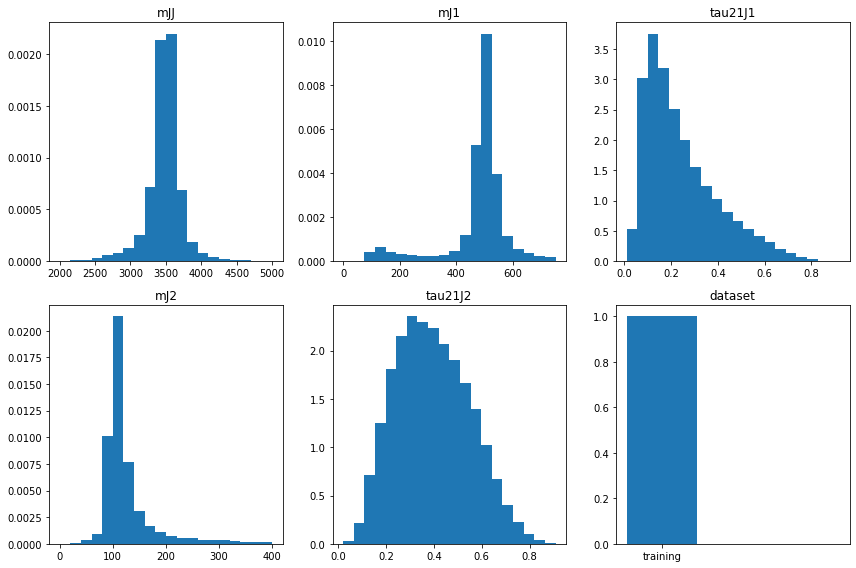

           mJJ       mJ1   tau21J1      mJ2   tau21J2
Event                                                
1      3365.54   80.8570  0.525579  724.380  0.457589
2      3950.80  300.6260  0.236429  279.153  0.109064
3      3235.36  547.1880  0.190855  155.299  0.450748
4      2847.28   31.8358  0.687075  210.065  0.471022
5      2447.00   97.6581  0.710543  264.451  0.280429
retrieved array of shape (999668, 6)
            mJJ      mJ1   tau21J1       mJ2   tau21J2   dataset
Event                                                           
613855  1132.28  256.442  0.584751  122.0150  0.721372  training
512940  1344.41  136.453  0.656294   45.9379  0.778359  training
54634   1356.00  221.527  0.348195   17.9149  0.791087  training
113180  1359.23  100.380  0.413897   66.5476  0.586281  training
124272  1369.24  153.433  0.509714   16.0895  0.653790  training


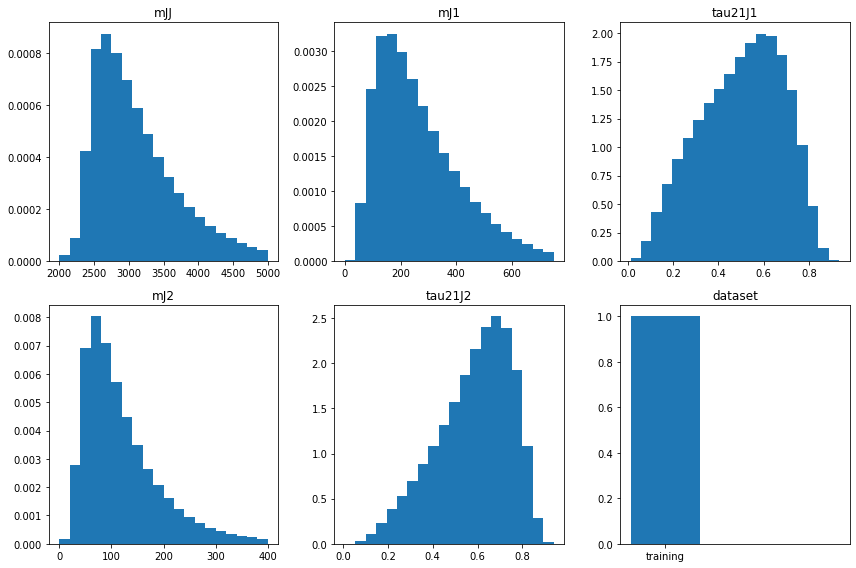

In [12]:
bkgname="rndbkgout_rnd.txt"
signame="rndsigout_rnd.txt"
siglist=prepare_mother_list(signame, -1, rg=1, testratio=0.0)
bkglist=prepare_mother_list(bkgname, -1, rg=1, testratio=0.0)

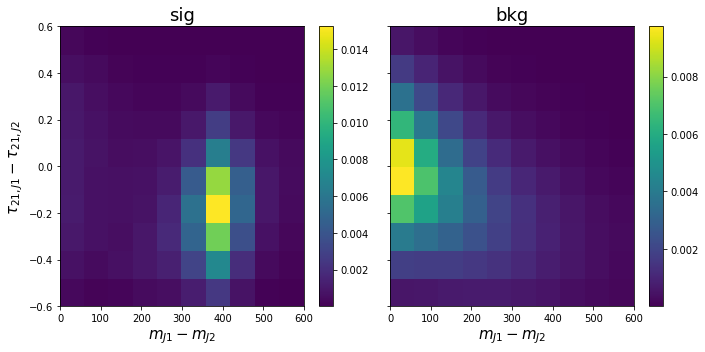

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
pltrange = ((0, 600), (-0.6, 0.6))
h = axs[0].hist2d(siglist.mJ1-siglist.mJ2, siglist.tau21J1-siglist.tau21J2, range=pltrange, density=True)
plt.colorbar(h[3], ax=axs[0])
axs[0].set_title('sig', fontsize=18)
h = axs[1].hist2d(bkglist.mJ1-bkglist.mJ2, bkglist.tau21J1-bkglist.tau21J2, range=pltrange, density=True)
plt.colorbar(h[3], ax=axs[1])
axs[1].set_title('bkg', fontsize=18)

axs[0].set_xlabel('$m_{J1}-m_{J2}$', fontsize=15)
axs[1].set_xlabel('$m_{J1}-m_{J2}$', fontsize=15)
axs[0].set_ylabel('$\\tau_{21, J1}-\\tau_{21, J2}$', fontsize=15)
plt.tight_layout()
plt.show()

In [14]:
np.random.seed(12)
sigindex = np.random.permutation(np.arange(len(siglist)))[:550]
bkgindex = np.random.permutation(np.arange(len(bkglist)))[:430000]
siglist = siglist.iloc[sigindex].copy()
bkglist = bkglist.iloc[bkgindex].copy()
#rawlist = np.concatenate((siglist.iloc[sigindex], bkglist.iloc[bkgindex]))

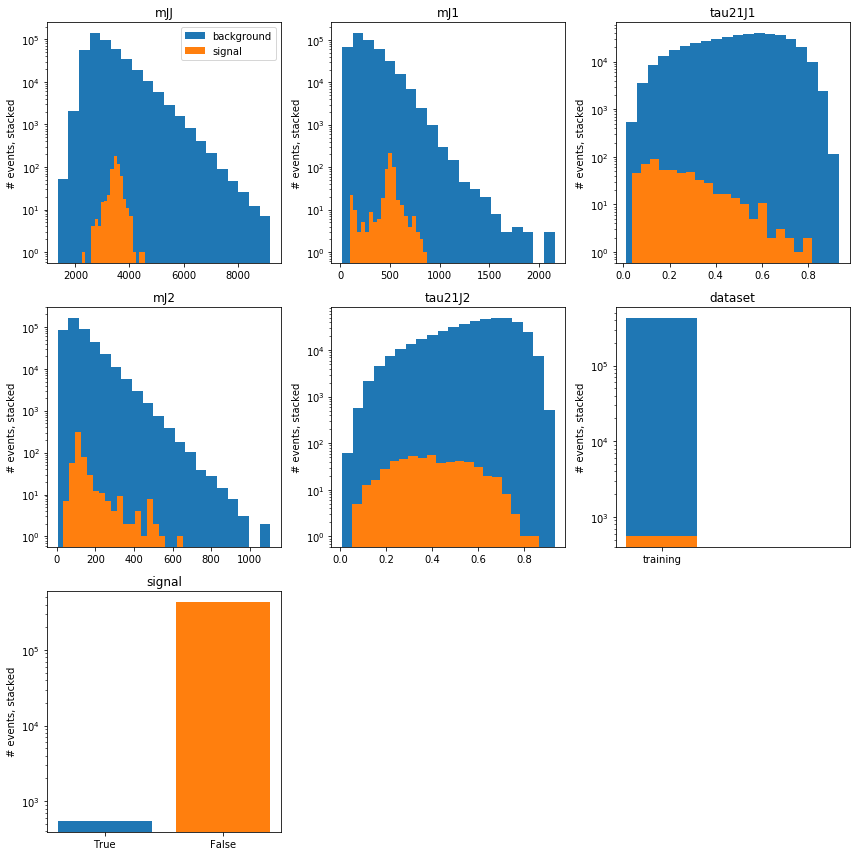

In [15]:
combined = combine_sig_bkg(siglist, bkglist)

In [16]:
Nsig_SR = combined.query('dataset == "training"').query('mJJ >= 3300').query('mJJ <= 3700').query('signal == 1').shape[0]
Nbkg_SR = combined.query('dataset == "training"').query('mJJ >= 3300').query('mJJ <= 3700').query('signal == 0').shape[0]
print('Nsig:', Nsig_SR)
print('Nbkg:', Nbkg_SR)
print('Nsig/Nbkg: {:.1e}'.format(Nsig_SR/Nbkg_SR))
print('Nsig/sqrt(Nbkg): {:.2f}'.format(Nsig_SR/np.sqrt(Nbkg_SR)))

Nsig: 415
Nbkg: 61090
Nsig/Nbkg: 6.8e-03
Nsig/sqrt(Nbkg): 1.68


### Train on signal region

In [32]:
data_bkg_train, data_sig_train, _ = prepare_data_train(3500,200,
                                             combined.query('dataset=="training"').drop(columns='dataset'),
                                             ignore=['signal'])

61505 events available for training
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_96 (Dense)                (None, 128)          512         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 128)          512         dense_96[0][0]                   
__________________________________________________________________________________________________
dense_97 (Dense)                (None, 128)          16512       batch_normalization_56[0][0]     
________________________________________________________

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 128)          512         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 128)          512         dense_124[0][0]                  
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 128)          16512       batch_normalization_74[0][0]     
___________________________________________________________________________________________

Batch:   0 Loss = 7.423059e-03,
Batch:  10 Loss = -7.205724e-01,
Batch:  20 Loss = -1.664787e+00,
Batch:  30 Loss = -1.860159e+00,
Batch:  40 Loss = -1.610415e+00,
Batch:  50 Loss = -2.073181e+00,
Batch:  60 Loss = -2.189142e+00,
Batch:  70 Loss = -2.767970e+00,
Batch:  80 Loss = -2.786944e+00,
Batch:  90 Loss = -2.919858e+00,
Batch: 100 Loss = -2.650575e+00,
Batch: 110 Loss = -2.989126e+00,
Batch: 120 Loss = -2.843311e+00,
Batch: 130 Loss = -3.163544e+00,
Batch: 140 Loss = -3.194451e+00,
Batch: 150 Loss = -2.743981e+00,
Batch: 160 Loss = -3.007690e+00,
Batch: 170 Loss = -3.017208e+00,
Batch: 180 Loss = -3.130490e+00,
Batch: 190 Loss = -2.964761e+00,
Batch: 200 Loss = -2.793247e+00,
Batch: 210 Loss = -3.172565e+00,
Batch: 220 Loss = -3.018731e+00,
Batch: 230 Loss = -3.299442e+00,
Batch: 240 Loss = -3.408542e+00,
Batch: 250 Loss = -2.792707e+00,
Batch: 260 Loss = -3.082754e+00,
Batch: 270 Loss = -3.173090e+00,
Batch: 280 Loss = -3.540535e+00,
Batch: 290 Loss = -2.861188e+00,
Batch: 300 

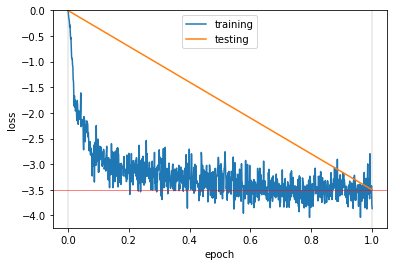

Batch:   0 Loss = -3.554920e+00,
Batch:  10 Loss = -3.643634e+00,
Batch:  20 Loss = -3.448779e+00,
Batch:  30 Loss = -3.303486e+00,
Batch:  40 Loss = -3.365945e+00,
Batch:  50 Loss = -2.981782e+00,
Batch:  60 Loss = -3.490742e+00,
Batch:  70 Loss = -3.609053e+00,
Batch:  80 Loss = -3.485389e+00,
Batch:  90 Loss = -3.561506e+00,
Batch: 100 Loss = -3.565068e+00,
Batch: 110 Loss = -3.219221e+00,
Batch: 120 Loss = -3.567050e+00,
Batch: 130 Loss = -3.471353e+00,
Batch: 140 Loss = -3.443822e+00,
Batch: 150 Loss = -3.545513e+00,
Batch: 160 Loss = -3.577402e+00,
Batch: 170 Loss = -3.554868e+00,
Batch: 180 Loss = -3.550952e+00,
Batch: 190 Loss = -3.326354e+00,
Batch: 200 Loss = -3.579467e+00,
Batch: 210 Loss = -3.438183e+00,
Batch: 220 Loss = -3.762392e+00,
Batch: 230 Loss = -3.692501e+00,
Batch: 240 Loss = -3.632592e+00,
Batch: 250 Loss = -3.685857e+00,
Batch: 260 Loss = -3.530264e+00,
Batch: 270 Loss = -3.302334e+00,
Batch: 280 Loss = -3.555292e+00,
Batch: 290 Loss = -3.431480e+00,
Batch: 300

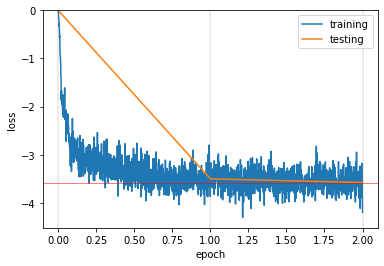

Batch:   0 Loss = -3.469090e+00,
Batch:  10 Loss = -3.603975e+00,
Batch:  20 Loss = -3.656296e+00,
Batch:  30 Loss = -3.405603e+00,
Batch:  40 Loss = -3.104199e+00,
Batch:  50 Loss = -2.246710e+00,
Batch:  60 Loss = -3.519087e+00,
Batch:  70 Loss = -2.958460e+00,
Batch:  80 Loss = -3.409681e+00,
Batch:  90 Loss = -3.274687e+00,
Batch: 100 Loss = -3.334268e+00,
Batch: 110 Loss = -3.035718e+00,
Batch: 120 Loss = -3.287983e+00,
Batch: 130 Loss = -3.543162e+00,
Batch: 140 Loss = -3.625105e+00,
Batch: 150 Loss = -3.359975e+00,
Batch: 160 Loss = -2.904355e+00,
Batch: 170 Loss = -3.834587e+00,
Batch: 180 Loss = -3.471663e+00,
Batch: 190 Loss = -3.866631e+00,
Batch: 200 Loss = -3.351888e+00,
Batch: 210 Loss = -3.061051e+00,
Batch: 220 Loss = -3.529011e+00,
Batch: 230 Loss = -3.619899e+00,
Batch: 240 Loss = -3.278767e+00,
Batch: 250 Loss = -3.337702e+00,
Batch: 260 Loss = -3.477709e+00,
Batch: 270 Loss = -3.519301e+00,
Batch: 280 Loss = -3.698496e+00,
Batch: 290 Loss = -3.133559e+00,
Batch: 300

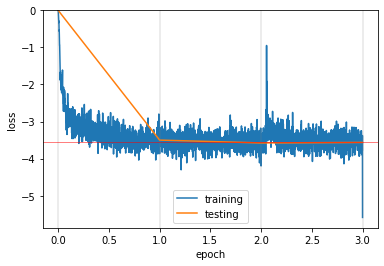

Batch:   0 Loss = -3.724450e+00,
Batch:  10 Loss = -3.513483e+00,
Batch:  20 Loss = -3.573975e+00,
Batch:  30 Loss = -3.536327e+00,
Batch:  40 Loss = -3.192379e+00,
Batch:  50 Loss = -3.560591e+00,
Batch:  60 Loss = -3.577197e+00,
Batch:  70 Loss = -3.875559e+00,
Batch:  80 Loss = -3.748649e+00,
Batch:  90 Loss = -3.683978e+00,
Batch: 100 Loss = -3.757298e+00,
Batch: 110 Loss = -3.624668e+00,
Batch: 120 Loss = -3.403845e+00,
Batch: 130 Loss = -3.656381e+00,
Batch: 140 Loss = -3.864715e+00,
Batch: 150 Loss = -3.653871e+00,
Batch: 160 Loss = -4.047888e+00,
Batch: 170 Loss = -3.292914e+00,
Batch: 180 Loss = -3.423588e+00,
Batch: 190 Loss = -3.585351e+00,
Batch: 200 Loss = -3.612185e+00,
Batch: 210 Loss = -3.620259e+00,
Batch: 220 Loss = -3.536522e+00,
Batch: 230 Loss = -3.430176e+00,
Batch: 240 Loss = -3.859547e+00,
Batch: 250 Loss = -3.900229e+00,
Batch: 260 Loss = -3.495866e+00,
Batch: 270 Loss = -3.653594e+00,
Batch: 280 Loss = -3.684870e+00,
Batch: 290 Loss = -3.326831e+00,
Batch: 300

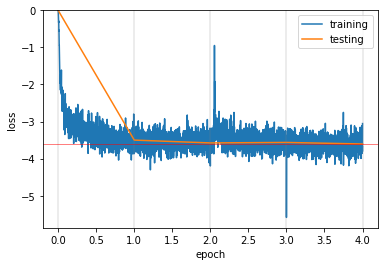

Batch:   0 Loss = -3.370127e+00,
Batch:  10 Loss = -3.429837e+00,
Batch:  20 Loss = -3.426286e+00,
Batch:  30 Loss = -3.563774e+00,
Batch:  40 Loss = -3.661728e+00,
Batch:  50 Loss = -3.678686e+00,
Batch:  60 Loss = -3.549569e+00,
Batch:  70 Loss = -3.535036e+00,
Batch:  80 Loss = -3.726219e+00,
Batch:  90 Loss = -3.728954e+00,
Batch: 100 Loss = -3.273781e+00,
Batch: 110 Loss = -3.630977e+00,
Batch: 120 Loss = -3.785264e+00,
Batch: 130 Loss = -3.665206e+00,
Batch: 140 Loss = -3.457608e+00,
Batch: 150 Loss = -3.601700e+00,
Batch: 160 Loss = -3.515665e+00,
Batch: 170 Loss = -3.735178e+00,
Batch: 180 Loss = -3.658346e+00,
Batch: 190 Loss = -3.768441e+00,
Batch: 200 Loss = -3.768260e+00,
Batch: 210 Loss = -3.646718e+00,
Batch: 220 Loss = -3.385085e+00,
Batch: 230 Loss = -3.563506e+00,
Batch: 240 Loss = -3.493767e+00,
Batch: 250 Loss = -3.789580e+00,
Batch: 260 Loss = -3.515929e+00,
Batch: 270 Loss = -3.954130e+00,
Batch: 280 Loss = -3.709387e+00,
Batch: 290 Loss = -3.708188e+00,
Batch: 300

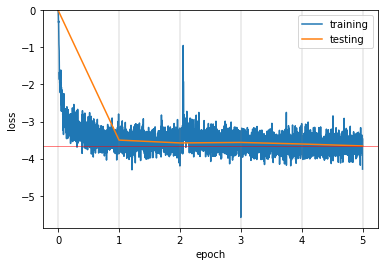

Batch:   0 Loss = -3.471837e+00,
Batch:  10 Loss = -3.672649e+00,
Batch:  20 Loss = -3.449534e+00,
Batch:  30 Loss = -3.334840e+00,
Batch:  40 Loss = -3.695179e+00,
Batch:  50 Loss = -3.352775e+00,
Batch:  60 Loss = -3.446792e+00,
Batch:  70 Loss = -3.279326e+00,
Batch:  80 Loss = -3.888234e+00,
Batch:  90 Loss = -3.956297e+00,
Batch: 100 Loss = -4.005350e+00,
Batch: 110 Loss = -3.708865e+00,
Batch: 120 Loss = -3.235631e+00,
Batch: 130 Loss = -3.753005e+00,
Batch: 140 Loss = -3.846726e+00,
Batch: 150 Loss = -3.853554e+00,
Batch: 160 Loss = -3.714636e+00,
Batch: 170 Loss = -3.722784e+00,
Batch: 180 Loss = -3.478311e+00,
Batch: 190 Loss = -3.651021e+00,
Batch: 200 Loss = -3.565063e+00,
Batch: 210 Loss = -3.571330e+00,
Batch: 220 Loss = -3.868936e+00,
Batch: 230 Loss = -3.662820e+00,
Batch: 240 Loss = -3.271847e+00,
Batch: 250 Loss = -3.695949e+00,
Batch: 260 Loss = -3.752583e+00,
Batch: 270 Loss = -3.752726e+00,
Batch: 280 Loss = -3.780095e+00,
Batch: 290 Loss = -3.673082e+00,
Batch: 300

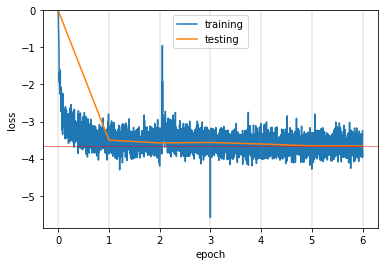

Batch:   0 Loss = -3.550321e+00,
Batch:  10 Loss = -3.800944e+00,
Batch:  20 Loss = -3.247772e+00,
Batch:  30 Loss = -4.103117e+00,
Batch:  40 Loss = -3.625192e+00,
Batch:  50 Loss = -3.498081e+00,
Batch:  60 Loss = -3.538394e+00,
Batch:  70 Loss = -3.469559e+00,
Batch:  80 Loss = -3.800362e+00,
Batch:  90 Loss = -3.825246e+00,
Batch: 100 Loss = -3.619747e+00,
Batch: 110 Loss = -3.528878e+00,
Batch: 120 Loss = -3.501735e+00,
Batch: 130 Loss = -3.547319e+00,
Batch: 140 Loss = -3.756248e+00,
Batch: 150 Loss = -3.269393e+00,
Batch: 160 Loss = -3.475031e+00,
Batch: 170 Loss = -4.032316e+00,
Batch: 180 Loss = -3.690920e+00,
Batch: 190 Loss = -3.532501e+00,
Batch: 200 Loss = -3.627096e+00,
Batch: 210 Loss = -3.706643e+00,
Batch: 220 Loss = -3.715497e+00,
Batch: 230 Loss = -3.355558e+00,
Batch: 240 Loss = -3.849254e+00,
Batch: 250 Loss = -3.635012e+00,
Batch: 260 Loss = -3.824566e+00,
Batch: 270 Loss = -3.524351e+00,
Batch: 280 Loss = -3.676513e+00,
Batch: 290 Loss = -3.583285e+00,
Batch: 300

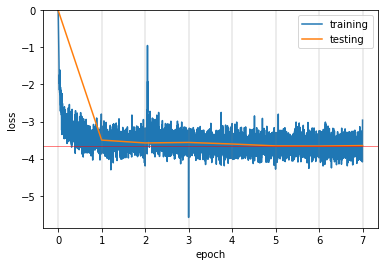

Batch:   0 Loss = -3.055020e+00,
Batch:  10 Loss = -3.885522e+00,
Batch:  20 Loss = -3.476653e+00,
Batch:  30 Loss = -3.444048e+00,
Batch:  40 Loss = -3.541429e+00,
Batch:  50 Loss = -3.643429e+00,
Batch:  60 Loss = -3.444737e+00,
Batch:  70 Loss = -3.863447e+00,
Batch:  80 Loss = -3.778938e+00,
Batch:  90 Loss = -3.764498e+00,
Batch: 100 Loss = -4.001374e+00,
Batch: 110 Loss = -3.709624e+00,
Batch: 120 Loss = -4.038344e+00,
Batch: 130 Loss = -3.497927e+00,
Batch: 140 Loss = -3.990177e+00,
Batch: 150 Loss = -3.728514e+00,
Batch: 160 Loss = -3.959652e+00,
Batch: 170 Loss = -3.897190e+00,
Batch: 180 Loss = -3.931624e+00,
Batch: 190 Loss = -3.650442e+00,
Batch: 200 Loss = -3.641065e+00,
Batch: 210 Loss = -3.576491e+00,
Batch: 220 Loss = -3.823239e+00,
Batch: 230 Loss = -3.716293e+00,
Batch: 240 Loss = -3.731944e+00,
Batch: 250 Loss = -3.424661e+00,
Batch: 260 Loss = -3.558898e+00,
Batch: 270 Loss = -3.691363e+00,
Batch: 280 Loss = -3.327361e+00,
Batch: 290 Loss = -3.608022e+00,
Batch: 300

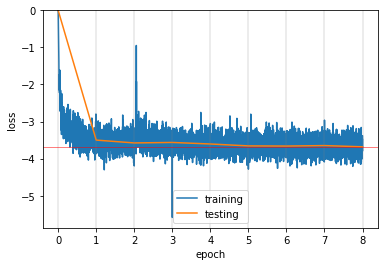

Batch:   0 Loss = -3.915675e+00,
Batch:  10 Loss = -4.239829e+00,
Batch:  20 Loss = -3.724951e+00,
Batch:  30 Loss = -3.729538e+00,
Batch:  40 Loss = -3.671425e+00,
Batch:  50 Loss = -3.360922e+00,
Batch:  60 Loss = -3.683360e+00,
Batch:  70 Loss = -3.608318e+00,
Batch:  80 Loss = -3.752590e+00,
Batch:  90 Loss = -3.783390e+00,
Batch: 100 Loss = -3.684733e+00,
Batch: 110 Loss = -3.951982e+00,
Batch: 120 Loss = -3.831884e+00,
Batch: 130 Loss = -3.730369e+00,
Batch: 140 Loss = -3.536024e+00,
Batch: 150 Loss = -4.143537e+00,
Batch: 160 Loss = -3.879443e+00,
Batch: 170 Loss = -3.578115e+00,
Batch: 180 Loss = -3.794649e+00,
Batch: 190 Loss = -3.469344e+00,
Batch: 200 Loss = -3.900805e+00,
Batch: 210 Loss = -3.701236e+00,
Batch: 220 Loss = -3.964523e+00,
Batch: 230 Loss = -3.662075e+00,
Batch: 240 Loss = -3.441873e+00,
Batch: 250 Loss = -3.635463e+00,
Batch: 260 Loss = -3.737045e+00,
Batch: 270 Loss = -3.597527e+00,
Batch: 280 Loss = -3.791300e+00,
Batch: 290 Loss = -3.552279e+00,
Batch: 300

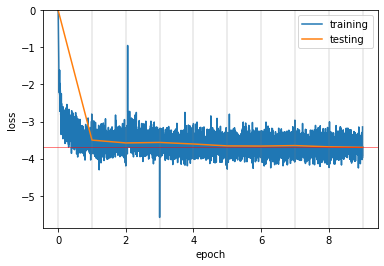

Batch:   0 Loss = -3.961129e+00,
Batch:  10 Loss = -3.491608e+00,
Batch:  20 Loss = -3.836190e+00,
Batch:  30 Loss = -3.825918e+00,
Batch:  40 Loss = -3.399942e+00,
Batch:  50 Loss = -3.544919e+00,
Batch:  60 Loss = -3.461198e+00,
Batch:  70 Loss = -3.647808e+00,
Batch:  80 Loss = -3.848368e+00,
Batch:  90 Loss = -3.552455e+00,
Batch: 100 Loss = -3.752182e+00,
Batch: 110 Loss = -3.647404e+00,
Batch: 120 Loss = -3.765479e+00,
Batch: 130 Loss = -3.776500e+00,
Batch: 140 Loss = -3.645191e+00,
Batch: 150 Loss = -3.586662e+00,
Batch: 160 Loss = -3.311943e+00,
Batch: 170 Loss = -3.799049e+00,
Batch: 180 Loss = -3.684993e+00,
Batch: 190 Loss = -3.765231e+00,
Batch: 200 Loss = -3.688671e+00,
Batch: 210 Loss = -3.610001e+00,
Batch: 220 Loss = -3.609034e+00,
Batch: 230 Loss = -3.952063e+00,
Batch: 240 Loss = -3.854025e+00,
Batch: 250 Loss = -3.816044e+00,
Batch: 260 Loss = -3.766008e+00,
Batch: 270 Loss = -3.906165e+00,
Batch: 280 Loss = -3.769641e+00,
Batch: 290 Loss = -3.280625e+00,
Batch: 300

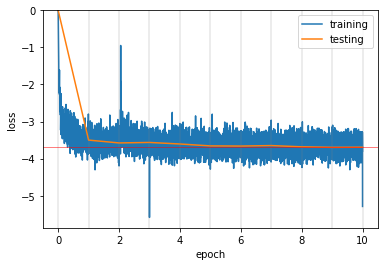

Batch:   0 Loss = -3.889813e+00,
Batch:  10 Loss = -3.647726e+00,
Batch:  20 Loss = -3.460283e+00,
Batch:  30 Loss = -3.575073e+00,
Batch:  40 Loss = -3.769771e+00,
Batch:  50 Loss = -3.702074e+00,
Batch:  60 Loss = -3.972545e+00,
Batch:  70 Loss = -3.453203e+00,
Batch:  80 Loss = -3.785219e+00,
Batch:  90 Loss = -3.325572e+00,
Batch: 100 Loss = -4.006446e+00,
Batch: 110 Loss = -3.760607e+00,
Batch: 120 Loss = -3.806762e+00,
Batch: 130 Loss = -3.716387e+00,
Batch: 140 Loss = -3.727129e+00,
Batch: 150 Loss = -3.585408e+00,
Batch: 160 Loss = -3.708263e+00,
Batch: 170 Loss = -3.768433e+00,
Batch: 180 Loss = -3.293247e+00,
Batch: 190 Loss = -3.356556e+00,
Batch: 200 Loss = -3.882122e+00,
Batch: 210 Loss = -3.594688e+00,
Batch: 220 Loss = -3.633483e+00,
Batch: 230 Loss = -3.614316e+00,
Batch: 240 Loss = -3.681232e+00,
Batch: 250 Loss = -3.843799e+00,
Batch: 260 Loss = -3.582089e+00,
Batch: 270 Loss = -3.560742e+00,
Batch: 280 Loss = -3.639873e+00,
Batch: 290 Loss = -3.719259e+00,
Batch: 300

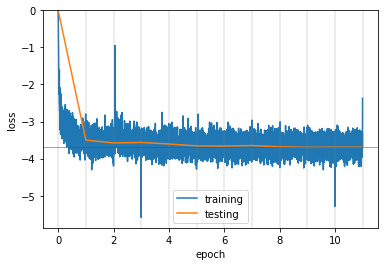

Batch:   0 Loss = -3.890810e+00,
Batch:  10 Loss = -3.700693e+00,
Batch:  20 Loss = -3.609639e+00,
Batch:  30 Loss = -3.435055e+00,
Batch:  40 Loss = -3.432812e+00,
Batch:  50 Loss = -3.767408e+00,
Batch:  60 Loss = -3.517131e+00,
Batch:  70 Loss = -3.857616e+00,
Batch:  80 Loss = -3.831925e+00,
Batch:  90 Loss = -3.529474e+00,
Batch: 100 Loss = -3.957545e+00,
Batch: 110 Loss = -3.366758e+00,
Batch: 120 Loss = -3.965491e+00,
Batch: 130 Loss = -3.827892e+00,
Batch: 140 Loss = -3.561688e+00,
Batch: 150 Loss = -3.821013e+00,
Batch: 160 Loss = -3.573109e+00,
Batch: 170 Loss = -3.475137e+00,
Batch: 180 Loss = -4.147051e+00,
Batch: 190 Loss = -3.499074e+00,
Batch: 200 Loss = -3.689752e+00,
Batch: 210 Loss = -3.712315e+00,
Batch: 220 Loss = -3.386273e+00,
Batch: 230 Loss = -3.384188e+00,
Batch: 240 Loss = -3.542145e+00,
Batch: 250 Loss = -3.586986e+00,
Batch: 260 Loss = -3.885340e+00,
Batch: 270 Loss = -3.456305e+00,
Batch: 280 Loss = -3.933457e+00,
Batch: 290 Loss = -3.860020e+00,
Batch: 300

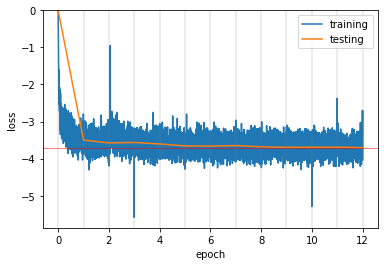

Batch:   0 Loss = -3.652210e+00,
Batch:  10 Loss = -3.712561e+00,
Batch:  20 Loss = -4.055615e+00,
Batch:  30 Loss = -3.514739e+00,
Batch:  40 Loss = -4.000099e+00,
Batch:  50 Loss = -3.871152e+00,
Batch:  60 Loss = -3.674526e+00,
Batch:  70 Loss = -3.961191e+00,
Batch:  80 Loss = -3.573420e+00,
Batch:  90 Loss = -3.540205e+00,
Batch: 100 Loss = -3.758668e+00,
Batch: 110 Loss = -3.861738e+00,
Batch: 120 Loss = -3.683414e+00,
Batch: 130 Loss = -3.412609e+00,
Batch: 140 Loss = -3.718455e+00,
Batch: 150 Loss = -3.837518e+00,
Batch: 160 Loss = -3.756117e+00,
Batch: 170 Loss = -3.658454e+00,
Batch: 180 Loss = -3.637585e+00,
Batch: 190 Loss = -3.661478e+00,
Batch: 200 Loss = -3.927319e+00,
Batch: 210 Loss = -3.455532e+00,
Batch: 220 Loss = -3.655928e+00,
Batch: 230 Loss = -3.660366e+00,
Batch: 240 Loss = -3.837739e+00,
Batch: 250 Loss = -3.453328e+00,
Batch: 260 Loss = -3.634244e+00,
Batch: 270 Loss = -3.661401e+00,
Batch: 280 Loss = -3.536642e+00,
Batch: 290 Loss = -3.839512e+00,
Batch: 300

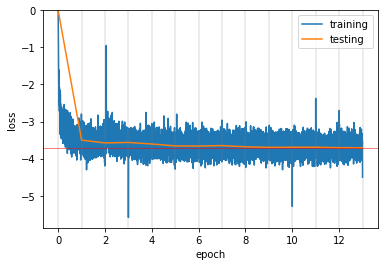

Batch:   0 Loss = -3.529715e+00,
Batch:  10 Loss = -3.733534e+00,
Batch:  20 Loss = -3.958814e+00,
Batch:  30 Loss = -3.808013e+00,
Batch:  40 Loss = -3.798736e+00,
Batch:  50 Loss = -3.886951e+00,
Batch:  60 Loss = -3.898542e+00,
Batch:  70 Loss = -3.988764e+00,
Batch:  80 Loss = -4.036673e+00,
Batch:  90 Loss = -3.654059e+00,
Batch: 100 Loss = -3.796462e+00,
Batch: 110 Loss = -3.421053e+00,
Batch: 120 Loss = -3.559061e+00,
Batch: 130 Loss = -3.606700e+00,
Batch: 140 Loss = -3.873174e+00,
Batch: 150 Loss = -3.632622e+00,
Batch: 160 Loss = -3.754399e+00,
Batch: 170 Loss = -3.713102e+00,
Batch: 180 Loss = -3.659272e+00,
Batch: 190 Loss = -3.685619e+00,
Batch: 200 Loss = -3.852775e+00,
Batch: 210 Loss = -3.370846e+00,
Batch: 220 Loss = -3.851032e+00,
Batch: 230 Loss = -3.499211e+00,
Batch: 240 Loss = -3.683350e+00,
Batch: 250 Loss = -3.443975e+00,
Batch: 260 Loss = -3.665823e+00,
Batch: 270 Loss = -3.778363e+00,
Batch: 280 Loss = -3.475524e+00,
Batch: 290 Loss = -3.873695e+00,
Batch: 300

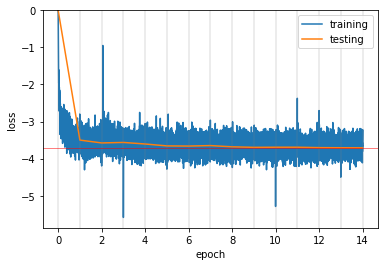

Batch:   0 Loss = -4.186182e+00,
Batch:  10 Loss = -3.444599e+00,
Batch:  20 Loss = -3.708258e+00,
Batch:  30 Loss = -3.870501e+00,
Batch:  40 Loss = -3.631014e+00,
Batch:  50 Loss = -3.663170e+00,
Batch:  60 Loss = -3.866519e+00,
Batch:  70 Loss = -3.547389e+00,
Batch:  80 Loss = -3.840641e+00,
Batch:  90 Loss = -4.070626e+00,
Batch: 100 Loss = -3.726059e+00,
Batch: 110 Loss = -3.892783e+00,
Batch: 120 Loss = -3.569894e+00,
Batch: 130 Loss = -3.522499e+00,
Batch: 140 Loss = -3.530347e+00,
Batch: 150 Loss = -3.581697e+00,
Batch: 160 Loss = -3.984546e+00,
Batch: 170 Loss = -3.705263e+00,
Batch: 180 Loss = -3.837946e+00,
Batch: 190 Loss = -3.476577e+00,
Batch: 200 Loss = -3.517051e+00,
Batch: 210 Loss = -3.714986e+00,
Batch: 220 Loss = -3.701804e+00,
Batch: 230 Loss = -3.623299e+00,
Batch: 240 Loss = -3.825284e+00,
Batch: 250 Loss = -3.772826e+00,
Batch: 260 Loss = -3.849203e+00,
Batch: 270 Loss = -3.406532e+00,
Batch: 280 Loss = -3.829682e+00,
Batch: 290 Loss = -3.686618e+00,
Batch: 300

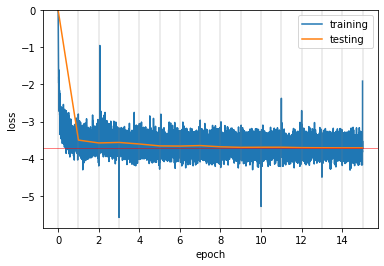

Batch:   0 Loss = -4.068557e+00,
Batch:  10 Loss = -3.995700e+00,
Batch:  20 Loss = -3.851767e+00,
Batch:  30 Loss = -3.598021e+00,
Batch:  40 Loss = -3.764516e+00,
Batch:  50 Loss = -3.553660e+00,
Batch:  60 Loss = -3.945789e+00,
Batch:  70 Loss = -3.496729e+00,
Batch:  80 Loss = -3.682232e+00,
Batch:  90 Loss = -3.694356e+00,
Batch: 100 Loss = -3.658686e+00,
Batch: 110 Loss = -3.870527e+00,
Batch: 120 Loss = -3.706260e+00,
Batch: 130 Loss = -3.492217e+00,
Batch: 140 Loss = -3.545457e+00,
Batch: 150 Loss = -3.636056e+00,
Batch: 160 Loss = -3.854057e+00,
Batch: 170 Loss = -3.721372e+00,
Batch: 180 Loss = -3.690013e+00,
Batch: 190 Loss = -3.884893e+00,
Batch: 200 Loss = -3.645605e+00,
Batch: 210 Loss = -3.692628e+00,
Batch: 220 Loss = -3.639466e+00,
Batch: 230 Loss = -3.353336e+00,
Batch: 240 Loss = -3.504610e+00,
Batch: 250 Loss = -3.982825e+00,
Batch: 260 Loss = -4.015733e+00,
Batch: 270 Loss = -3.855890e+00,
Batch: 280 Loss = -3.674864e+00,
Batch: 290 Loss = -3.868601e+00,
Batch: 300

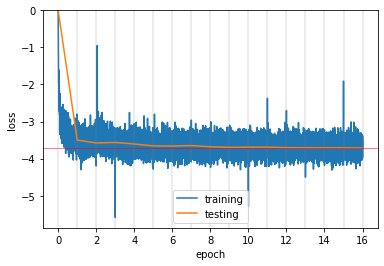

Batch:   0 Loss = -3.452047e+00,
Batch:  10 Loss = -3.677139e+00,
Batch:  20 Loss = -3.653250e+00,
Batch:  30 Loss = -3.682849e+00,
Batch:  40 Loss = -3.787810e+00,
Batch:  50 Loss = -3.375459e+00,
Batch:  60 Loss = -3.508813e+00,
Batch:  70 Loss = -3.689784e+00,
Batch:  80 Loss = -3.682000e+00,
Batch:  90 Loss = -3.467278e+00,
Batch: 100 Loss = -4.181171e+00,
Batch: 110 Loss = -3.653752e+00,
Batch: 120 Loss = -3.379587e+00,
Batch: 130 Loss = -3.826434e+00,
Batch: 140 Loss = -3.562549e+00,
Batch: 150 Loss = -3.760212e+00,
Batch: 160 Loss = -3.796636e+00,
Batch: 170 Loss = -4.006443e+00,
Batch: 180 Loss = -3.847955e+00,
Batch: 190 Loss = -3.841161e+00,
Batch: 200 Loss = -3.972076e+00,
Batch: 210 Loss = -3.769478e+00,
Batch: 220 Loss = -3.717670e+00,
Batch: 230 Loss = -3.937766e+00,
Batch: 240 Loss = -3.868663e+00,
Batch: 250 Loss = -3.753980e+00,
Batch: 260 Loss = -3.299938e+00,
Batch: 270 Loss = -3.657501e+00,
Batch: 280 Loss = -3.895976e+00,
Batch: 290 Loss = -3.760282e+00,
Batch: 300

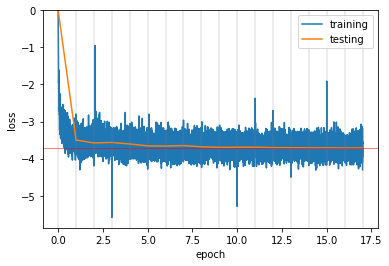

Batch:   0 Loss = -3.944815e+00,
Batch:  10 Loss = -3.849446e+00,
Batch:  20 Loss = -3.645900e+00,
Batch:  30 Loss = -3.787126e+00,
Batch:  40 Loss = -3.705459e+00,
Batch:  50 Loss = -4.219075e+00,
Batch:  60 Loss = -3.654724e+00,
Batch:  70 Loss = -3.734131e+00,
Batch:  80 Loss = -3.794203e+00,
Batch:  90 Loss = -4.047248e+00,
Batch: 100 Loss = -3.556385e+00,
Batch: 110 Loss = -3.586770e+00,
Batch: 120 Loss = -3.791579e+00,
Batch: 130 Loss = -3.737777e+00,
Batch: 140 Loss = -3.415751e+00,
Batch: 150 Loss = -3.602665e+00,
Batch: 160 Loss = -3.864462e+00,
Batch: 170 Loss = -3.318652e+00,
Batch: 180 Loss = -3.804989e+00,
Batch: 190 Loss = -3.811164e+00,
Batch: 200 Loss = -3.631053e+00,
Batch: 210 Loss = -3.862680e+00,
Batch: 220 Loss = -3.721046e+00,
Batch: 230 Loss = -3.862818e+00,
Batch: 240 Loss = -3.893323e+00,
Batch: 250 Loss = -3.585737e+00,
Batch: 260 Loss = -3.919718e+00,
Batch: 270 Loss = -3.924892e+00,
Batch: 280 Loss = -3.685679e+00,
Batch: 290 Loss = -3.858029e+00,
Batch: 300

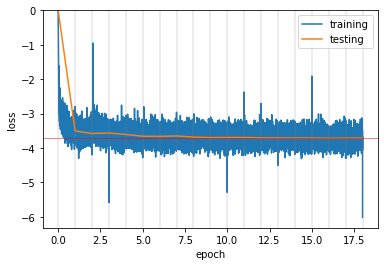

Batch:   0 Loss = -3.597866e+00,
Batch:  10 Loss = -3.625034e+00,
Batch:  20 Loss = -3.718551e+00,
Batch:  30 Loss = -3.523726e+00,
Batch:  40 Loss = -3.779877e+00,
Batch:  50 Loss = -3.652991e+00,
Batch:  60 Loss = -3.637323e+00,
Batch:  70 Loss = -3.665720e+00,
Batch:  80 Loss = -3.779594e+00,
Batch:  90 Loss = -3.728910e+00,
Batch: 100 Loss = -3.820411e+00,
Batch: 110 Loss = -3.575124e+00,
Batch: 120 Loss = -3.666435e+00,
Batch: 130 Loss = -3.755877e+00,
Batch: 140 Loss = -3.877192e+00,
Batch: 150 Loss = -3.780413e+00,
Batch: 160 Loss = -3.766386e+00,
Batch: 170 Loss = -3.889344e+00,
Batch: 180 Loss = -3.765494e+00,
Batch: 190 Loss = -3.393755e+00,
Batch: 200 Loss = -3.469994e+00,
Batch: 210 Loss = -3.644317e+00,
Batch: 220 Loss = -3.532983e+00,
Batch: 230 Loss = -3.358391e+00,
Batch: 240 Loss = -3.325261e+00,
Batch: 250 Loss = -3.532231e+00,
Batch: 260 Loss = -3.782017e+00,
Batch: 270 Loss = -3.817731e+00,
Batch: 280 Loss = -3.743366e+00,
Batch: 290 Loss = -3.686166e+00,
Batch: 300

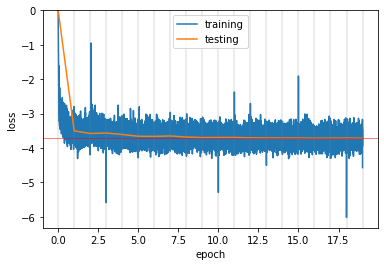

Batch:   0 Loss = -3.830749e+00,
Batch:  10 Loss = -3.542576e+00,
Batch:  20 Loss = -3.718681e+00,
Batch:  30 Loss = -3.746747e+00,
Batch:  40 Loss = -3.784351e+00,
Batch:  50 Loss = -3.545633e+00,
Batch:  60 Loss = -3.502913e+00,
Batch:  70 Loss = -3.572264e+00,
Batch:  80 Loss = -3.621618e+00,
Batch:  90 Loss = -3.690333e+00,
Batch: 100 Loss = -3.575154e+00,
Batch: 110 Loss = -3.905512e+00,
Batch: 120 Loss = -3.975738e+00,
Batch: 130 Loss = -3.928665e+00,
Batch: 140 Loss = -3.706078e+00,
Batch: 150 Loss = -3.707357e+00,
Batch: 160 Loss = -3.785979e+00,
Batch: 170 Loss = -3.775424e+00,
Batch: 180 Loss = -3.658780e+00,
Batch: 190 Loss = -3.831656e+00,
Batch: 200 Loss = -4.009533e+00,
Batch: 210 Loss = -3.744523e+00,
Batch: 220 Loss = -3.712654e+00,
Batch: 230 Loss = -3.478414e+00,
Batch: 240 Loss = -3.915838e+00,
Batch: 250 Loss = -3.711278e+00,
Batch: 260 Loss = -3.680836e+00,
Batch: 270 Loss = -3.884014e+00,
Batch: 280 Loss = -4.000556e+00,
Batch: 290 Loss = -3.686041e+00,
Batch: 300

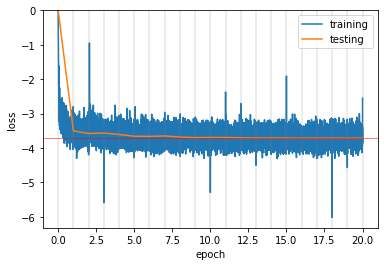

Batch:   0 Loss = -3.813684e+00,
Batch:  10 Loss = -3.610031e+00,
Batch:  20 Loss = -3.327132e+00,
Batch:  30 Loss = -3.751196e+00,
Batch:  40 Loss = -3.746827e+00,
Batch:  50 Loss = -3.533923e+00,
Batch:  60 Loss = -3.703456e+00,
Batch:  70 Loss = -3.429200e+00,
Batch:  80 Loss = -3.618066e+00,
Batch:  90 Loss = -3.458631e+00,
Batch: 100 Loss = -3.693122e+00,
Batch: 110 Loss = -3.831398e+00,
Batch: 120 Loss = -3.813432e+00,
Batch: 130 Loss = -3.491383e+00,
Batch: 140 Loss = -3.523460e+00,
Batch: 150 Loss = -3.539858e+00,
Batch: 160 Loss = -3.827738e+00,
Batch: 170 Loss = -3.749295e+00,
Batch: 180 Loss = -3.698052e+00,
Batch: 190 Loss = -3.440250e+00,
Batch: 200 Loss = -3.534525e+00,
Batch: 210 Loss = -3.865295e+00,
Batch: 220 Loss = -3.374508e+00,
Batch: 230 Loss = -3.447211e+00,
Batch: 240 Loss = -3.809368e+00,
Batch: 250 Loss = -3.957273e+00,
Batch: 260 Loss = -3.433853e+00,
Batch: 270 Loss = -3.599794e+00,
Batch: 280 Loss = -3.843924e+00,
Batch: 290 Loss = -3.760014e+00,
Batch: 300

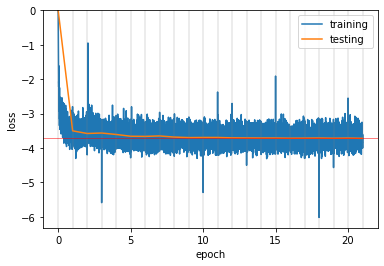

Batch:   0 Loss = -3.709962e+00,
Batch:  10 Loss = -3.640613e+00,
Batch:  20 Loss = -3.650760e+00,
Batch:  30 Loss = -3.753043e+00,
Batch:  40 Loss = -3.663768e+00,
Batch:  50 Loss = -3.766300e+00,
Batch:  60 Loss = -3.711574e+00,
Batch:  70 Loss = -3.672979e+00,
Batch:  80 Loss = -3.725106e+00,
Batch:  90 Loss = -3.655822e+00,
Batch: 100 Loss = -3.712092e+00,
Batch: 110 Loss = -3.632951e+00,
Batch: 120 Loss = -3.670450e+00,
Batch: 130 Loss = -3.552396e+00,
Batch: 140 Loss = -3.804773e+00,
Batch: 150 Loss = -3.535073e+00,
Batch: 160 Loss = -3.505797e+00,
Batch: 170 Loss = -3.767543e+00,
Batch: 180 Loss = -4.118875e+00,
Batch: 190 Loss = -3.925361e+00,
Batch: 200 Loss = -3.793078e+00,
Batch: 210 Loss = -3.764893e+00,
Batch: 220 Loss = -3.577255e+00,
Batch: 230 Loss = -3.830723e+00,
Batch: 240 Loss = -3.864199e+00,
Batch: 250 Loss = -3.574502e+00,
Batch: 260 Loss = -3.704527e+00,
Batch: 270 Loss = -3.566362e+00,
Batch: 280 Loss = -3.393687e+00,
Batch: 290 Loss = -3.689359e+00,
Batch: 300

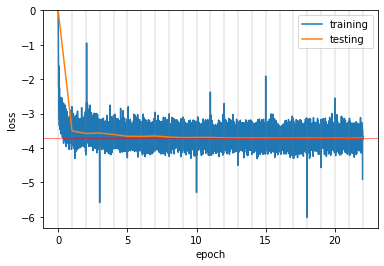

Batch:   0 Loss = -3.637702e+00,
Batch:  10 Loss = -3.445658e+00,
Batch:  20 Loss = -3.858341e+00,
Batch:  30 Loss = -3.636640e+00,
Batch:  40 Loss = -3.837762e+00,
Batch:  50 Loss = -3.653137e+00,
Batch:  60 Loss = -4.165194e+00,
Batch:  70 Loss = -3.698513e+00,
Batch:  80 Loss = -3.838952e+00,
Batch:  90 Loss = -3.692669e+00,
Batch: 100 Loss = -3.619873e+00,
Batch: 110 Loss = -3.931619e+00,
Batch: 120 Loss = -3.610321e+00,
Batch: 130 Loss = -3.784893e+00,
Batch: 140 Loss = -3.652664e+00,
Batch: 150 Loss = -3.404090e+00,
Batch: 160 Loss = -3.733179e+00,
Batch: 170 Loss = -3.599138e+00,
Batch: 180 Loss = -3.758281e+00,
Batch: 190 Loss = -3.552797e+00,
Batch: 200 Loss = -3.866888e+00,
Batch: 210 Loss = -3.613011e+00,
Batch: 220 Loss = -3.587234e+00,
Batch: 230 Loss = -3.620181e+00,
Batch: 240 Loss = -3.527788e+00,
Batch: 250 Loss = -4.233640e+00,
Batch: 260 Loss = -4.050981e+00,
Batch: 270 Loss = -3.627807e+00,
Batch: 280 Loss = -3.794380e+00,
Batch: 290 Loss = -3.559397e+00,
Batch: 300

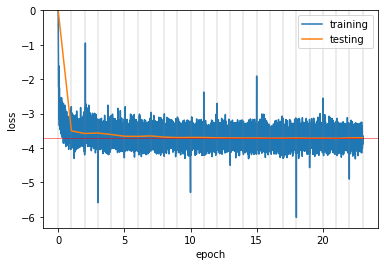

Batch:   0 Loss = -3.993407e+00,
Batch:  10 Loss = -4.005733e+00,
Batch:  20 Loss = -3.557848e+00,
Batch:  30 Loss = -3.844972e+00,
Batch:  40 Loss = -3.792409e+00,
Batch:  50 Loss = -3.725824e+00,
Batch:  60 Loss = -3.871447e+00,
Batch:  70 Loss = -3.799374e+00,
Batch:  80 Loss = -3.774893e+00,
Batch:  90 Loss = -3.323893e+00,
Batch: 100 Loss = -4.187948e+00,
Batch: 110 Loss = -3.734910e+00,
Batch: 120 Loss = -3.682728e+00,
Batch: 130 Loss = -3.683402e+00,
Batch: 140 Loss = -3.568917e+00,
Batch: 150 Loss = -3.285558e+00,
Batch: 160 Loss = -3.733166e+00,
Batch: 170 Loss = -3.747180e+00,
Batch: 180 Loss = -3.714179e+00,
Batch: 190 Loss = -3.698021e+00,
Batch: 200 Loss = -3.823224e+00,
Batch: 210 Loss = -3.897082e+00,
Batch: 220 Loss = -3.646482e+00,
Batch: 230 Loss = -3.800581e+00,
Batch: 240 Loss = -3.831181e+00,
Batch: 250 Loss = -3.868754e+00,
Batch: 260 Loss = -3.781662e+00,
Batch: 270 Loss = -3.785946e+00,
Batch: 280 Loss = -3.752267e+00,
Batch: 290 Loss = -3.972356e+00,
Batch: 300

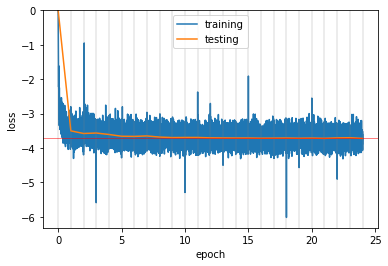

Batch:   0 Loss = -3.623497e+00,
Batch:  10 Loss = -3.945086e+00,
Batch:  20 Loss = -3.814416e+00,
Batch:  30 Loss = -3.764683e+00,
Batch:  40 Loss = -3.700607e+00,
Batch:  50 Loss = -3.754990e+00,
Batch:  60 Loss = -3.736315e+00,
Batch:  70 Loss = -3.719877e+00,
Batch:  80 Loss = -3.857403e+00,
Batch:  90 Loss = -3.796110e+00,
Batch: 100 Loss = -3.498832e+00,
Batch: 110 Loss = -3.833113e+00,
Batch: 120 Loss = -3.454389e+00,
Batch: 130 Loss = -3.554456e+00,
Batch: 140 Loss = -3.712474e+00,
Batch: 150 Loss = -3.493040e+00,
Batch: 160 Loss = -3.707705e+00,
Batch: 170 Loss = -3.751554e+00,
Batch: 180 Loss = -3.538690e+00,
Batch: 190 Loss = -3.863602e+00,
Batch: 200 Loss = -3.912124e+00,
Batch: 210 Loss = -3.573763e+00,
Batch: 220 Loss = -4.028223e+00,
Batch: 230 Loss = -3.889482e+00,
Batch: 240 Loss = -3.733567e+00,
Batch: 250 Loss = -3.997591e+00,
Batch: 260 Loss = -4.053465e+00,
Batch: 270 Loss = -3.669873e+00,
Batch: 280 Loss = -3.796392e+00,
Batch: 290 Loss = -3.820511e+00,
Batch: 300

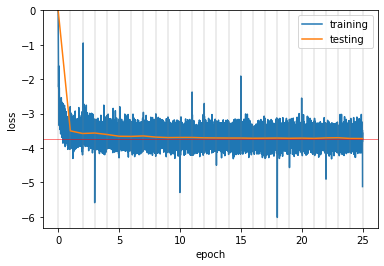

Batch:   0 Loss = -3.682585e+00,
Batch:  10 Loss = -3.814293e+00,
Batch:  20 Loss = -3.347530e+00,
Batch:  30 Loss = -4.016931e+00,
Batch:  40 Loss = -3.613843e+00,
Batch:  50 Loss = -3.687192e+00,
Batch:  60 Loss = -3.484800e+00,
Batch:  70 Loss = -3.827488e+00,
Batch:  80 Loss = -4.069234e+00,
Batch:  90 Loss = -4.022004e+00,
Batch: 100 Loss = -3.810195e+00,
Batch: 110 Loss = -4.106158e+00,
Batch: 120 Loss = -3.707117e+00,
Batch: 130 Loss = -3.814293e+00,
Batch: 140 Loss = -3.619972e+00,
Batch: 150 Loss = -3.820070e+00,
Batch: 160 Loss = -3.837729e+00,
Batch: 170 Loss = -4.056232e+00,
Batch: 180 Loss = -3.705621e+00,
Batch: 190 Loss = -3.532759e+00,
Batch: 200 Loss = -3.552113e+00,
Batch: 210 Loss = -3.668687e+00,
Batch: 220 Loss = -3.726753e+00,
Batch: 230 Loss = -3.660622e+00,
Batch: 240 Loss = -3.883813e+00,
Batch: 250 Loss = -3.763829e+00,
Batch: 260 Loss = -3.871518e+00,
Batch: 270 Loss = -4.045302e+00,
Batch: 280 Loss = -3.647171e+00,
Batch: 290 Loss = -3.992761e+00,
Batch: 300

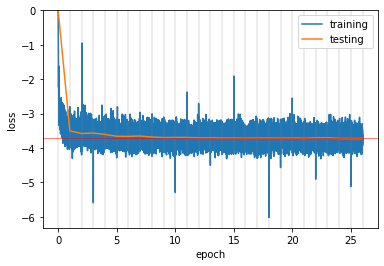

Batch:   0 Loss = -4.000520e+00,
Batch:  10 Loss = -4.141655e+00,
Batch:  20 Loss = -3.860539e+00,
Batch:  30 Loss = -3.602666e+00,
Batch:  40 Loss = -3.985076e+00,
Batch:  50 Loss = -3.488749e+00,
Batch:  60 Loss = -3.641582e+00,
Batch:  70 Loss = -3.687311e+00,
Batch:  80 Loss = -3.719340e+00,
Batch:  90 Loss = -3.867669e+00,
Batch: 100 Loss = -3.781340e+00,
Batch: 110 Loss = -3.823062e+00,
Batch: 120 Loss = -4.040979e+00,
Batch: 130 Loss = -3.480950e+00,
Batch: 140 Loss = -3.806170e+00,
Batch: 150 Loss = -3.402943e+00,
Batch: 160 Loss = -3.604401e+00,
Batch: 170 Loss = -3.845443e+00,
Batch: 180 Loss = -3.790598e+00,
Batch: 190 Loss = -3.684221e+00,
Batch: 200 Loss = -3.570751e+00,
Batch: 210 Loss = -3.678723e+00,
Batch: 220 Loss = -3.652333e+00,
Batch: 230 Loss = -3.515291e+00,
Batch: 240 Loss = -3.642093e+00,
Batch: 250 Loss = -3.571307e+00,
Batch: 260 Loss = -3.707338e+00,
Batch: 270 Loss = -3.627977e+00,
Batch: 280 Loss = -3.793099e+00,
Batch: 290 Loss = -3.902591e+00,
Batch: 300

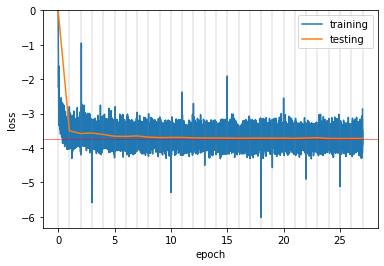

Batch:   0 Loss = -3.642949e+00,
Batch:  10 Loss = -3.826995e+00,
Batch:  20 Loss = -4.021057e+00,
Batch:  30 Loss = -3.806303e+00,
Batch:  40 Loss = -3.872266e+00,
Batch:  50 Loss = -3.799014e+00,
Batch:  60 Loss = -3.646011e+00,
Batch:  70 Loss = -3.713283e+00,
Batch:  80 Loss = -3.543541e+00,
Batch:  90 Loss = -3.697186e+00,
Batch: 100 Loss = -3.834492e+00,
Batch: 110 Loss = -3.650210e+00,
Batch: 120 Loss = -3.957602e+00,
Batch: 130 Loss = -4.093688e+00,
Batch: 140 Loss = -3.832459e+00,
Batch: 150 Loss = -3.825561e+00,
Batch: 160 Loss = -3.710712e+00,
Batch: 170 Loss = -3.621395e+00,
Batch: 180 Loss = -3.806125e+00,
Batch: 190 Loss = -3.675704e+00,
Batch: 200 Loss = -3.989769e+00,
Batch: 210 Loss = -3.820634e+00,
Batch: 220 Loss = -3.974729e+00,
Batch: 230 Loss = -3.861831e+00,
Batch: 240 Loss = -3.546867e+00,
Batch: 250 Loss = -3.256855e+00,
Batch: 260 Loss = -3.756365e+00,
Batch: 270 Loss = -3.788327e+00,
Batch: 280 Loss = -3.987645e+00,
Batch: 290 Loss = -3.901267e+00,
Batch: 300

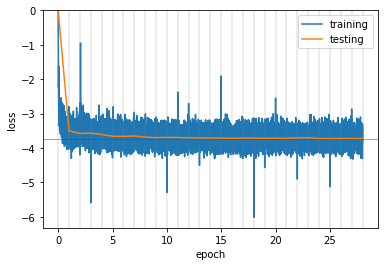

Batch:   0 Loss = -4.031819e+00,
Batch:  10 Loss = -3.871024e+00,
Batch:  20 Loss = -3.711198e+00,
Batch:  30 Loss = -3.635240e+00,
Batch:  40 Loss = -3.581796e+00,
Batch:  50 Loss = -3.709702e+00,
Batch:  60 Loss = -3.644699e+00,
Batch:  70 Loss = -3.565180e+00,
Batch:  80 Loss = -3.875710e+00,
Batch:  90 Loss = -3.810393e+00,
Batch: 100 Loss = -3.745386e+00,
Batch: 110 Loss = -3.564568e+00,
Batch: 120 Loss = -3.783458e+00,
Batch: 130 Loss = -3.555887e+00,
Batch: 140 Loss = -3.956655e+00,
Batch: 150 Loss = -3.359188e+00,
Batch: 160 Loss = -3.317420e+00,
Batch: 170 Loss = -3.418681e+00,
Batch: 180 Loss = -3.763216e+00,
Batch: 190 Loss = -3.834907e+00,
Batch: 200 Loss = -3.795562e+00,
Batch: 210 Loss = -3.792884e+00,
Batch: 220 Loss = -3.777618e+00,
Batch: 230 Loss = -3.680866e+00,
Batch: 240 Loss = -4.024410e+00,
Batch: 250 Loss = -3.640791e+00,
Batch: 260 Loss = -3.811209e+00,
Batch: 270 Loss = -3.771360e+00,
Batch: 280 Loss = -4.112808e+00,
Batch: 290 Loss = -3.805937e+00,
Batch: 300

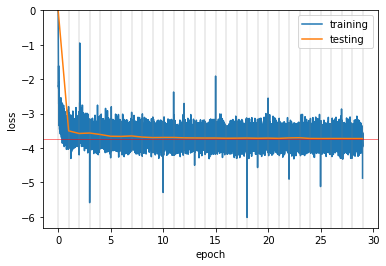

Batch:   0 Loss = -3.512444e+00,
Batch:  10 Loss = -4.118141e+00,
Batch:  20 Loss = -3.954342e+00,
Batch:  30 Loss = -3.591277e+00,
Batch:  40 Loss = -3.206198e+00,
Batch:  50 Loss = -3.787965e+00,
Batch:  60 Loss = -3.834920e+00,
Batch:  70 Loss = -3.721661e+00,
Batch:  80 Loss = -3.784011e+00,
Batch:  90 Loss = -4.267818e+00,
Batch: 100 Loss = -3.691220e+00,
Batch: 110 Loss = -3.466690e+00,
Batch: 120 Loss = -3.515562e+00,
Batch: 130 Loss = -3.333534e+00,
Batch: 140 Loss = -3.783058e+00,
Batch: 150 Loss = -4.011309e+00,
Batch: 160 Loss = -3.832166e+00,
Batch: 170 Loss = -3.754729e+00,
Batch: 180 Loss = -3.782251e+00,
Batch: 190 Loss = -3.757985e+00,
Batch: 200 Loss = -3.759779e+00,
Batch: 210 Loss = -3.656564e+00,
Batch: 220 Loss = -3.808796e+00,
Batch: 230 Loss = -3.750035e+00,
Batch: 240 Loss = -3.958422e+00,
Batch: 250 Loss = -3.983231e+00,
Batch: 260 Loss = -3.567397e+00,
Batch: 270 Loss = -3.918813e+00,
Batch: 280 Loss = -3.654504e+00,
Batch: 290 Loss = -4.066079e+00,
Batch: 300

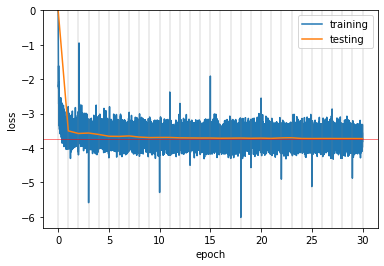

In [33]:
sig_epochs = 30
sigdist, losses, test_losses =train_iflow(combined.drop(columns='signal') ,M=3500,
                                          deltaM=200,
                                         issig=True, batchsize=64, lr=5e-4,
                                          epochs=sig_epochs,
                                         weight_decay=1e-4)

Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully


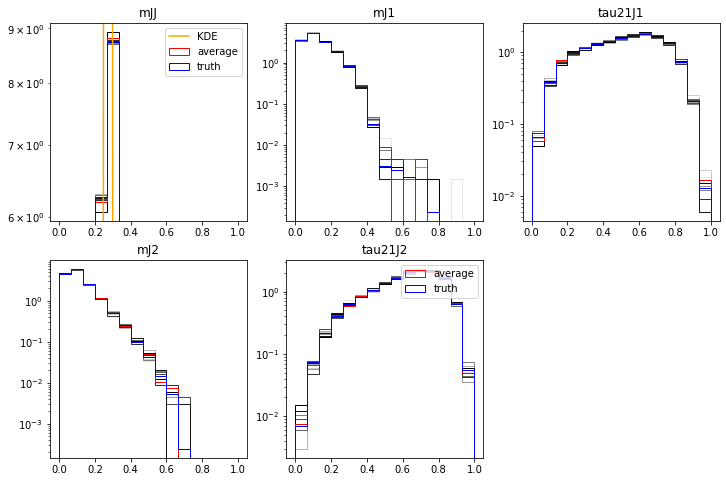

In [34]:
last_epochs = np.arange(sig_epochs-10, sig_epochs)
last_epochs = last_epochs[last_epochs >= 0]
plot_learned_distributions(sigdist, last_epochs, 'sig_', 10000,
                           truth=data_sig_train.drop(columns='signal'), special_dim=0)

### Train on side band

369045 events available for training
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_152 (Dense)               (None, 128)          512         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 128)          512         dense_152[0][0]                  
__________________________________________________________________________________________________
dense_153 (Dense)               (None, 128)          16512       batch_normalization_92[0][0]     
______________________________________________________

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_180 (Dense)               (None, 128)          512         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 128)          512         dense_180[0][0]                  
__________________________________________________________________________________________________
dense_181 (Dense)               (None, 128)          16512       batch_normalization_110[0][0]    
___________________________________________________________________________________________

running #2
running #2
Batch:   0 Loss = 5.190961e-02,
Batch:  10 Loss = -2.514918e+00,
Batch:  20 Loss = -3.121931e+00,
Batch:  30 Loss = -3.367843e+00,
Batch:  40 Loss = -2.961775e+00,
Batch:  50 Loss = -3.515418e+00,
Batch:  60 Loss = -3.358876e+00,
Batch:  70 Loss = -3.199184e+00,
Batch:  80 Loss = -3.498055e+00,
Batch:  90 Loss = -3.327127e+00,
Batch: 100 Loss = -3.749266e+00,
Batch: 110 Loss = -3.435260e+00,
Batch: 120 Loss = -3.235818e+00,
Batch: 130 Loss = -3.383831e+00,
Batch: 140 Loss = -3.421285e+00,
Batch: 150 Loss = -3.425409e+00,
Batch: 160 Loss = -3.313713e+00,
Batch: 170 Loss = -3.379760e+00,
Batch: 180 Loss = -3.568220e+00,
Batch: 190 Loss = -3.165819e+00,
Batch: 200 Loss = -3.366195e+00,
Batch: 210 Loss = -3.723895e+00,
Batch: 220 Loss = -3.567668e+00,
Batch: 230 Loss = -3.465035e+00,
Batch: 240 Loss = -3.508471e+00,
Batch: 250 Loss = -2.747886e+00,
Batch: 260 Loss = 2.482929e+00,
Batch: 270 Loss = -2.537548e+00,
Batch: 280 Loss = -2.892884e+00,
Batch: 290 Loss = -3.18

Batch: 2440 Loss = -3.928115e+00,
Batch: 2450 Loss = -3.533199e+00,
Batch: 2460 Loss = -3.864048e+00,
Batch: 2470 Loss = -3.501016e+00,
Batch: 2480 Loss = -3.801601e+00,
Batch: 2490 Loss = -4.180802e+00,
Batch: 2500 Loss = -3.949072e+00,
Batch: 2510 Loss = -3.764464e+00,
Batch: 2520 Loss = -3.910500e+00,
Batch: 2530 Loss = -3.761411e+00,
Batch: 2540 Loss = -3.768200e+00,
Batch: 2550 Loss = -4.102916e+00,
Batch: 2560 Loss = -3.833306e+00,
Batch: 2570 Loss = -3.878477e+00,
Batch: 2580 Loss = -3.844025e+00,
Batch: 2590 Loss = -3.912771e+00,
Batch: 2600 Loss = -3.649940e+00,
Batch: 2610 Loss = -3.834926e+00,
Batch: 2620 Loss = -4.082612e+00,
Batch: 2630 Loss = -4.110537e+00,
Batch: 2640 Loss = -3.849734e+00,
Batch: 2650 Loss = -3.942322e+00,
Batch: 2660 Loss = -4.126313e+00,
Batch: 2670 Loss = -4.085657e+00,
Batch: 2680 Loss = -3.773245e+00,
Batch: 2690 Loss = -3.947933e+00,
Batch: 2700 Loss = -4.074243e+00,
Batch: 2710 Loss = -3.810045e+00,
Batch: 2720 Loss = -3.923046e+00,
Batch: 2730 Lo

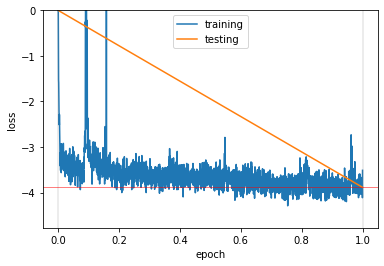

Batch:   0 Loss = -3.896749e+00,
Batch:  10 Loss = -4.029350e+00,
Batch:  20 Loss = -3.795570e+00,
Batch:  30 Loss = -3.972355e+00,
Batch:  40 Loss = -3.916953e+00,
Batch:  50 Loss = -4.043026e+00,
Batch:  60 Loss = -3.811582e+00,
Batch:  70 Loss = -3.671282e+00,
Batch:  80 Loss = -3.638184e+00,
Batch:  90 Loss = -4.079877e+00,
Batch: 100 Loss = -3.670079e+00,
Batch: 110 Loss = -3.609017e+00,
Batch: 120 Loss = -4.033372e+00,
Batch: 130 Loss = -4.059979e+00,
Batch: 140 Loss = -3.801743e+00,
Batch: 150 Loss = -3.752684e+00,
Batch: 160 Loss = -4.023997e+00,
Batch: 170 Loss = -3.748187e+00,
Batch: 180 Loss = -4.032550e+00,
Batch: 190 Loss = -3.821434e+00,
Batch: 200 Loss = -3.938724e+00,
Batch: 210 Loss = -3.970422e+00,
Batch: 220 Loss = -3.876560e+00,
Batch: 230 Loss = -4.128813e+00,
Batch: 240 Loss = -3.992039e+00,
Batch: 250 Loss = -3.397642e+00,
Batch: 260 Loss = -3.918946e+00,
Batch: 270 Loss = -4.160374e+00,
Batch: 280 Loss = -3.679399e+00,
Batch: 290 Loss = -3.883326e+00,
Batch: 300

Batch: 2440 Loss = -3.862295e+00,
Batch: 2450 Loss = -3.864736e+00,
Batch: 2460 Loss = -3.575005e+00,
Batch: 2470 Loss = -3.836650e+00,
Batch: 2480 Loss = -3.962510e+00,
Batch: 2490 Loss = -3.965066e+00,
Batch: 2500 Loss = -3.937279e+00,
Batch: 2510 Loss = -3.905226e+00,
Batch: 2520 Loss = -4.123830e+00,
Batch: 2530 Loss = -4.274550e+00,
Batch: 2540 Loss = -3.935486e+00,
Batch: 2550 Loss = -3.990164e+00,
Batch: 2560 Loss = -4.036139e+00,
Batch: 2570 Loss = -4.023934e+00,
Batch: 2580 Loss = -3.758844e+00,
Batch: 2590 Loss = -3.985418e+00,
Batch: 2600 Loss = -3.835293e+00,
Batch: 2610 Loss = -3.707809e+00,
Batch: 2620 Loss = -3.647191e+00,
Batch: 2630 Loss = -4.126317e+00,
Batch: 2640 Loss = -3.935832e+00,
Batch: 2650 Loss = -4.166736e+00,
Batch: 2660 Loss = -4.082850e+00,
Batch: 2670 Loss = -4.075859e+00,
Batch: 2680 Loss = -3.935194e+00,
Batch: 2690 Loss = -4.148799e+00,
Batch: 2700 Loss = -3.934674e+00,
Batch: 2710 Loss = -3.799659e+00,
Batch: 2720 Loss = -4.014381e+00,
Batch: 2730 Lo

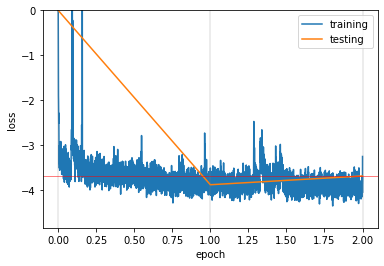

Batch:   0 Loss = -3.346453e+00,
Batch:  10 Loss = -3.455614e+00,
Batch:  20 Loss = -3.686003e+00,
Batch:  30 Loss = -3.662086e+00,
Batch:  40 Loss = -3.982727e+00,
Batch:  50 Loss = -3.904147e+00,
Batch:  60 Loss = -3.697938e+00,
Batch:  70 Loss = -3.704236e+00,
Batch:  80 Loss = -3.790137e+00,
Batch:  90 Loss = -4.248258e+00,
Batch: 100 Loss = -3.951531e+00,
Batch: 110 Loss = -3.826800e+00,
Batch: 120 Loss = -4.005082e+00,
Batch: 130 Loss = -3.803779e+00,
Batch: 140 Loss = -3.969054e+00,
Batch: 150 Loss = -3.782310e+00,
Batch: 160 Loss = -3.932605e+00,
Batch: 170 Loss = -4.117674e+00,
Batch: 180 Loss = -4.001113e+00,
Batch: 190 Loss = -3.795994e+00,
Batch: 200 Loss = -4.008693e+00,
Batch: 210 Loss = -3.871537e+00,
Batch: 220 Loss = -4.047318e+00,
Batch: 230 Loss = -3.789851e+00,
Batch: 240 Loss = -4.091753e+00,
Batch: 250 Loss = -3.974024e+00,
Batch: 260 Loss = -3.929265e+00,
Batch: 270 Loss = -3.960875e+00,
Batch: 280 Loss = -3.943046e+00,
Batch: 290 Loss = -3.868312e+00,
Batch: 300

Batch: 2440 Loss = -4.001340e+00,
Batch: 2450 Loss = -3.906307e+00,
Batch: 2460 Loss = -4.120661e+00,
Batch: 2470 Loss = -3.932279e+00,
Batch: 2480 Loss = -4.110240e+00,
Batch: 2490 Loss = -4.070000e+00,
Batch: 2500 Loss = -4.271603e+00,
Batch: 2510 Loss = -4.056639e+00,
Batch: 2520 Loss = -4.068362e+00,
Batch: 2530 Loss = -3.964293e+00,
Batch: 2540 Loss = -4.135787e+00,
Batch: 2550 Loss = -3.850798e+00,
Batch: 2560 Loss = -3.995117e+00,
Batch: 2570 Loss = -3.735915e+00,
Batch: 2580 Loss = -4.187897e+00,
Batch: 2590 Loss = -3.982106e+00,
Batch: 2600 Loss = -4.071419e+00,
Batch: 2610 Loss = -3.983074e+00,
Batch: 2620 Loss = -3.779140e+00,
Batch: 2630 Loss = -4.087287e+00,
Batch: 2640 Loss = -3.883644e+00,
Batch: 2650 Loss = -3.872619e+00,
Batch: 2660 Loss = -4.067603e+00,
Batch: 2670 Loss = -3.906359e+00,
Batch: 2680 Loss = -4.140180e+00,
Batch: 2690 Loss = -3.920249e+00,
Batch: 2700 Loss = -3.948860e+00,
Batch: 2710 Loss = -4.324820e+00,
Batch: 2720 Loss = -3.902777e+00,
Batch: 2730 Lo

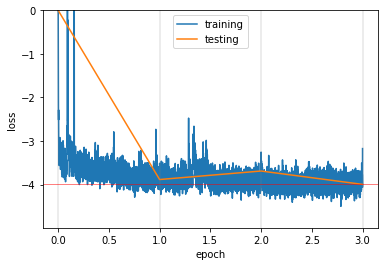

Batch:   0 Loss = -4.098753e+00,
Batch:  10 Loss = -4.018857e+00,
Batch:  20 Loss = -4.024772e+00,
Batch:  30 Loss = -4.128065e+00,
Batch:  40 Loss = -3.916834e+00,
Batch:  50 Loss = -4.275668e+00,
Batch:  60 Loss = -3.940229e+00,
Batch:  70 Loss = -4.064969e+00,
Batch:  80 Loss = -3.958758e+00,
Batch:  90 Loss = -4.114621e+00,
Batch: 100 Loss = -4.083628e+00,
Batch: 110 Loss = -3.880898e+00,
Batch: 120 Loss = -3.932618e+00,
Batch: 130 Loss = -3.988069e+00,
Batch: 140 Loss = -4.138025e+00,
Batch: 150 Loss = -3.738947e+00,
Batch: 160 Loss = -4.076380e+00,
Batch: 170 Loss = -3.756578e+00,
Batch: 180 Loss = -3.932477e+00,
Batch: 190 Loss = -3.936018e+00,
Batch: 200 Loss = -4.050991e+00,
Batch: 210 Loss = -3.963757e+00,
Batch: 220 Loss = -3.685203e+00,
Batch: 230 Loss = -4.183350e+00,
Batch: 240 Loss = -3.926668e+00,
Batch: 250 Loss = -3.913678e+00,
Batch: 260 Loss = -4.225631e+00,
Batch: 270 Loss = -3.925570e+00,
Batch: 280 Loss = -4.170906e+00,
Batch: 290 Loss = -4.036432e+00,
Batch: 300

Batch: 2440 Loss = -3.834795e+00,
Batch: 2450 Loss = -3.819654e+00,
Batch: 2460 Loss = -3.913685e+00,
Batch: 2470 Loss = -3.896743e+00,
Batch: 2480 Loss = -4.050932e+00,
Batch: 2490 Loss = -3.987583e+00,
Batch: 2500 Loss = -3.813758e+00,
Batch: 2510 Loss = -4.052353e+00,
Batch: 2520 Loss = -4.153061e+00,
Batch: 2530 Loss = -4.119470e+00,
Batch: 2540 Loss = -3.924348e+00,
Batch: 2550 Loss = -3.895651e+00,
Batch: 2560 Loss = -4.253829e+00,
Batch: 2570 Loss = -4.085390e+00,
Batch: 2580 Loss = -3.948638e+00,
Batch: 2590 Loss = -3.922358e+00,
Batch: 2600 Loss = -4.002937e+00,
Batch: 2610 Loss = -3.909287e+00,
Batch: 2620 Loss = -3.823017e+00,
Batch: 2630 Loss = -4.006994e+00,
Batch: 2640 Loss = -4.097290e+00,
Batch: 2650 Loss = -4.287634e+00,
Batch: 2660 Loss = -4.173963e+00,
Batch: 2670 Loss = -3.763718e+00,
Batch: 2680 Loss = -3.865693e+00,
Batch: 2690 Loss = -3.964430e+00,
Batch: 2700 Loss = -3.931488e+00,
Batch: 2710 Loss = -3.920315e+00,
Batch: 2720 Loss = -3.860116e+00,
Batch: 2730 Lo

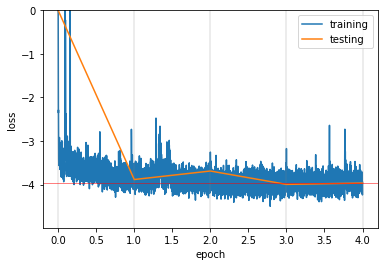

Batch:   0 Loss = -3.721937e+00,
Batch:  10 Loss = -3.953779e+00,
Batch:  20 Loss = -4.151851e+00,
Batch:  30 Loss = -3.795348e+00,
Batch:  40 Loss = -4.071774e+00,
Batch:  50 Loss = -4.132851e+00,
Batch:  60 Loss = -3.628167e+00,
Batch:  70 Loss = -3.923329e+00,
Batch:  80 Loss = -4.172130e+00,
Batch:  90 Loss = -3.815984e+00,
Batch: 100 Loss = -3.909406e+00,
Batch: 110 Loss = -4.251914e+00,
Batch: 120 Loss = -3.804211e+00,
Batch: 130 Loss = -3.938480e+00,
Batch: 140 Loss = -4.066302e+00,
Batch: 150 Loss = -4.029587e+00,
Batch: 160 Loss = -3.991845e+00,
Batch: 170 Loss = -3.982223e+00,
Batch: 180 Loss = -4.081109e+00,
Batch: 190 Loss = -3.635440e+00,
Batch: 200 Loss = -3.923353e+00,
Batch: 210 Loss = -3.878127e+00,
Batch: 220 Loss = -3.684202e+00,
Batch: 230 Loss = -3.941316e+00,
Batch: 240 Loss = -4.153207e+00,
Batch: 250 Loss = -4.188411e+00,
Batch: 260 Loss = -3.931629e+00,
Batch: 270 Loss = -3.958803e+00,
Batch: 280 Loss = -3.968067e+00,
Batch: 290 Loss = -3.976499e+00,
Batch: 300

Batch: 2440 Loss = -3.875947e+00,
Batch: 2450 Loss = -3.833653e+00,
Batch: 2460 Loss = -4.081723e+00,
Batch: 2470 Loss = -4.029161e+00,
Batch: 2480 Loss = -3.935239e+00,
Batch: 2490 Loss = -3.709170e+00,
Batch: 2500 Loss = -3.983798e+00,
Batch: 2510 Loss = -3.960478e+00,
Batch: 2520 Loss = -3.738932e+00,
Batch: 2530 Loss = -3.735241e+00,
Batch: 2540 Loss = -3.773766e+00,
Batch: 2550 Loss = -4.128466e+00,
Batch: 2560 Loss = -4.037960e+00,
Batch: 2570 Loss = -4.148449e+00,
Batch: 2580 Loss = -4.178923e+00,
Batch: 2590 Loss = -4.025465e+00,
Batch: 2600 Loss = -3.609035e+00,
Batch: 2610 Loss = -4.166859e+00,
Batch: 2620 Loss = -3.776476e+00,
Batch: 2630 Loss = -4.099097e+00,
Batch: 2640 Loss = -3.950448e+00,
Batch: 2650 Loss = -4.226827e+00,
Batch: 2660 Loss = -4.013845e+00,
Batch: 2670 Loss = -3.967585e+00,
Batch: 2680 Loss = -3.701087e+00,
Batch: 2690 Loss = -4.010285e+00,
Batch: 2700 Loss = -3.806372e+00,
Batch: 2710 Loss = -4.011657e+00,
Batch: 2720 Loss = -4.089391e+00,
Batch: 2730 Lo

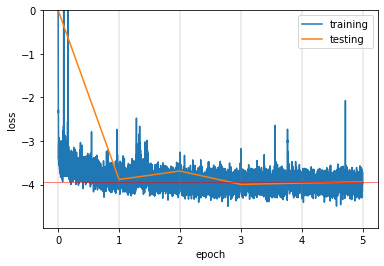

Batch:   0 Loss = -3.891334e+00,
Batch:  10 Loss = -4.055351e+00,
Batch:  20 Loss = -4.082452e+00,
Batch:  30 Loss = -4.048841e+00,
Batch:  40 Loss = -3.913341e+00,
Batch:  50 Loss = -4.052521e+00,
Batch:  60 Loss = -3.919901e+00,
Batch:  70 Loss = -3.969199e+00,
Batch:  80 Loss = -3.993201e+00,
Batch:  90 Loss = -4.251623e+00,
Batch: 100 Loss = -3.923474e+00,
Batch: 110 Loss = -4.008632e+00,
Batch: 120 Loss = -3.876270e+00,
Batch: 130 Loss = -4.281511e+00,
Batch: 140 Loss = -4.124952e+00,
Batch: 150 Loss = -3.672865e+00,
Batch: 160 Loss = -3.958888e+00,
Batch: 170 Loss = -4.142280e+00,
Batch: 180 Loss = -3.986299e+00,
Batch: 190 Loss = -4.141522e+00,
Batch: 200 Loss = -4.088813e+00,
Batch: 210 Loss = -4.159979e+00,
Batch: 220 Loss = -3.941698e+00,
Batch: 230 Loss = -3.865147e+00,
Batch: 240 Loss = -3.983174e+00,
Batch: 250 Loss = -4.061403e+00,
Batch: 260 Loss = -3.650889e+00,
Batch: 270 Loss = -3.935374e+00,
Batch: 280 Loss = -3.773602e+00,
Batch: 290 Loss = -4.024175e+00,
Batch: 300

Batch: 2440 Loss = -3.939978e+00,
Batch: 2450 Loss = -4.027641e+00,
Batch: 2460 Loss = -3.975476e+00,
Batch: 2470 Loss = -4.111106e+00,
Batch: 2480 Loss = -3.707621e+00,
Batch: 2490 Loss = -3.785514e+00,
Batch: 2500 Loss = -3.985005e+00,
Batch: 2510 Loss = -3.946786e+00,
Batch: 2520 Loss = -3.887449e+00,
Batch: 2530 Loss = -4.094786e+00,
Batch: 2540 Loss = -3.929793e+00,
Batch: 2550 Loss = -3.996391e+00,
Batch: 2560 Loss = -4.042063e+00,
Batch: 2570 Loss = -4.048658e+00,
Batch: 2580 Loss = -3.888174e+00,
Batch: 2590 Loss = -4.032585e+00,
Batch: 2600 Loss = -3.955776e+00,
Batch: 2610 Loss = -4.117805e+00,
Batch: 2620 Loss = -3.945713e+00,
Batch: 2630 Loss = -4.095845e+00,
Batch: 2640 Loss = -4.183918e+00,
Batch: 2650 Loss = -3.886592e+00,
Batch: 2660 Loss = -3.915270e+00,
Batch: 2670 Loss = -3.869823e+00,
Batch: 2680 Loss = -4.054690e+00,
Batch: 2690 Loss = -3.928452e+00,
Batch: 2700 Loss = -3.834693e+00,
Batch: 2710 Loss = -4.285904e+00,
Batch: 2720 Loss = -3.994073e+00,
Batch: 2730 Lo

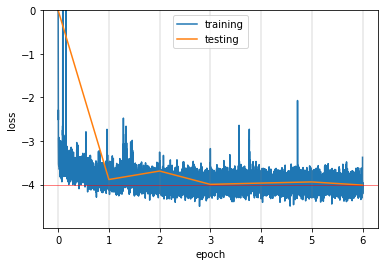

Batch:   0 Loss = -3.939028e+00,
Batch:  10 Loss = -3.908345e+00,
Batch:  20 Loss = -3.843064e+00,
Batch:  30 Loss = -3.908810e+00,
Batch:  40 Loss = -3.913039e+00,
Batch:  50 Loss = -4.000528e+00,
Batch:  60 Loss = -3.851938e+00,
Batch:  70 Loss = -3.872365e+00,
Batch:  80 Loss = -3.992864e+00,
Batch:  90 Loss = -4.196631e+00,
Batch: 100 Loss = -3.934410e+00,
Batch: 110 Loss = -4.158019e+00,
Batch: 120 Loss = -4.088075e+00,
Batch: 130 Loss = -4.066644e+00,
Batch: 140 Loss = -4.162469e+00,
Batch: 150 Loss = -3.945234e+00,
Batch: 160 Loss = -4.041524e+00,
Batch: 170 Loss = -4.015249e+00,
Batch: 180 Loss = -4.139599e+00,
Batch: 190 Loss = -4.351123e+00,
Batch: 200 Loss = -4.120889e+00,
Batch: 210 Loss = -4.050263e+00,
Batch: 220 Loss = -3.975243e+00,
Batch: 230 Loss = -4.045186e+00,
Batch: 240 Loss = -4.156168e+00,
Batch: 250 Loss = -3.955303e+00,
Batch: 260 Loss = -4.216428e+00,
Batch: 270 Loss = -4.081070e+00,
Batch: 280 Loss = -3.813727e+00,
Batch: 290 Loss = -4.050361e+00,
Batch: 300

Batch: 2440 Loss = -3.782702e+00,
Batch: 2450 Loss = -4.148568e+00,
Batch: 2460 Loss = -3.972027e+00,
Batch: 2470 Loss = -3.897716e+00,
Batch: 2480 Loss = -4.123176e+00,
Batch: 2490 Loss = -3.805999e+00,
Batch: 2500 Loss = -3.999558e+00,
Batch: 2510 Loss = -4.137575e+00,
Batch: 2520 Loss = -4.025113e+00,
Batch: 2530 Loss = -3.889411e+00,
Batch: 2540 Loss = -3.961110e+00,
Batch: 2550 Loss = -3.789228e+00,
Batch: 2560 Loss = -4.005268e+00,
Batch: 2570 Loss = -3.680938e+00,
Batch: 2580 Loss = -3.964822e+00,
Batch: 2590 Loss = -3.992141e+00,
Batch: 2600 Loss = -3.880501e+00,
Batch: 2610 Loss = -4.099934e+00,
Batch: 2620 Loss = -4.029598e+00,
Batch: 2630 Loss = -3.920354e+00,
Batch: 2640 Loss = -4.094623e+00,
Batch: 2650 Loss = -3.964902e+00,
Batch: 2660 Loss = -4.057269e+00,
Batch: 2670 Loss = -3.944450e+00,
Batch: 2680 Loss = -4.086014e+00,
Batch: 2690 Loss = -3.774755e+00,
Batch: 2700 Loss = -3.992804e+00,
Batch: 2710 Loss = -3.810220e+00,
Batch: 2720 Loss = -4.161266e+00,
Batch: 2730 Lo

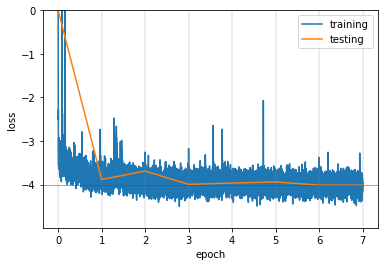

Batch:   0 Loss = -3.892756e+00,
Batch:  10 Loss = -3.924208e+00,
Batch:  20 Loss = -3.937250e+00,
Batch:  30 Loss = -4.078175e+00,
Batch:  40 Loss = -4.039303e+00,
Batch:  50 Loss = -3.933356e+00,
Batch:  60 Loss = -3.938095e+00,
Batch:  70 Loss = -4.005580e+00,
Batch:  80 Loss = -3.902168e+00,
Batch:  90 Loss = -3.856503e+00,
Batch: 100 Loss = -3.856804e+00,
Batch: 110 Loss = -4.275832e+00,
Batch: 120 Loss = -4.092249e+00,
Batch: 130 Loss = -4.347457e+00,
Batch: 140 Loss = -4.234615e+00,
Batch: 150 Loss = -3.735286e+00,
Batch: 160 Loss = -3.920590e+00,
Batch: 170 Loss = -3.995808e+00,
Batch: 180 Loss = -4.172353e+00,
Batch: 190 Loss = -4.047466e+00,
Batch: 200 Loss = -3.842316e+00,
Batch: 210 Loss = -4.226487e+00,
Batch: 220 Loss = -3.914971e+00,
Batch: 230 Loss = -4.002028e+00,
Batch: 240 Loss = -3.852707e+00,
Batch: 250 Loss = -4.288628e+00,
Batch: 260 Loss = -3.981850e+00,
Batch: 270 Loss = -3.991927e+00,
Batch: 280 Loss = -4.143468e+00,
Batch: 290 Loss = -4.074699e+00,
Batch: 300

Batch: 2440 Loss = -4.159684e+00,
Batch: 2450 Loss = -4.124298e+00,
Batch: 2460 Loss = -4.256969e+00,
Batch: 2470 Loss = -4.109958e+00,
Batch: 2480 Loss = -4.197528e+00,
Batch: 2490 Loss = -4.266380e+00,
Batch: 2500 Loss = -4.239831e+00,
Batch: 2510 Loss = -3.730326e+00,
Batch: 2520 Loss = -3.971569e+00,
Batch: 2530 Loss = -3.698334e+00,
Batch: 2540 Loss = -4.223466e+00,
Batch: 2550 Loss = -4.123167e+00,
Batch: 2560 Loss = -4.067422e+00,
Batch: 2570 Loss = -4.038620e+00,
Batch: 2580 Loss = -3.763258e+00,
Batch: 2590 Loss = -3.904306e+00,
Batch: 2600 Loss = -3.908043e+00,
Batch: 2610 Loss = -4.094580e+00,
Batch: 2620 Loss = -3.964855e+00,
Batch: 2630 Loss = -3.925922e+00,
Batch: 2640 Loss = -3.826219e+00,
Batch: 2650 Loss = -4.009572e+00,
Batch: 2660 Loss = -3.926984e+00,
Batch: 2670 Loss = -4.098695e+00,
Batch: 2680 Loss = -3.981503e+00,
Batch: 2690 Loss = -3.970826e+00,
Batch: 2700 Loss = -3.763489e+00,
Batch: 2710 Loss = -3.893356e+00,
Batch: 2720 Loss = -3.796520e+00,
Batch: 2730 Lo

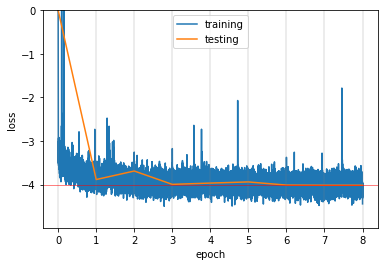

Batch:   0 Loss = -3.781714e+00,
Batch:  10 Loss = -4.032311e+00,
Batch:  20 Loss = -4.049828e+00,
Batch:  30 Loss = -4.246031e+00,
Batch:  40 Loss = -4.193581e+00,
Batch:  50 Loss = -4.096507e+00,
Batch:  60 Loss = -3.968208e+00,
Batch:  70 Loss = -4.050017e+00,
Batch:  80 Loss = -4.106067e+00,
Batch:  90 Loss = -4.025825e+00,
Batch: 100 Loss = -4.050898e+00,
Batch: 110 Loss = -3.804820e+00,
Batch: 120 Loss = -4.108898e+00,
Batch: 130 Loss = -3.961146e+00,
Batch: 140 Loss = -3.886296e+00,
Batch: 150 Loss = -4.230821e+00,
Batch: 160 Loss = -4.177567e+00,
Batch: 170 Loss = -3.952914e+00,
Batch: 180 Loss = -4.121585e+00,
Batch: 190 Loss = -3.913416e+00,
Batch: 200 Loss = -4.042953e+00,
Batch: 210 Loss = -4.081682e+00,
Batch: 220 Loss = -3.960044e+00,
Batch: 230 Loss = -4.047612e+00,
Batch: 240 Loss = -3.843470e+00,
Batch: 250 Loss = -4.116707e+00,
Batch: 260 Loss = -3.980728e+00,
Batch: 270 Loss = -4.055044e+00,
Batch: 280 Loss = -4.096362e+00,
Batch: 290 Loss = -4.125140e+00,
Batch: 300

Batch: 2440 Loss = -4.092420e+00,
Batch: 2450 Loss = -4.074203e+00,
Batch: 2460 Loss = -3.994737e+00,
Batch: 2470 Loss = -3.992344e+00,
Batch: 2480 Loss = -3.906241e+00,
Batch: 2490 Loss = -4.093333e+00,
Batch: 2500 Loss = -3.830978e+00,
Batch: 2510 Loss = -3.987479e+00,
Batch: 2520 Loss = -4.115265e+00,
Batch: 2530 Loss = -4.271012e+00,
Batch: 2540 Loss = -4.039064e+00,
Batch: 2550 Loss = -3.943994e+00,
Batch: 2560 Loss = -4.033289e+00,
Batch: 2570 Loss = -4.015442e+00,
Batch: 2580 Loss = -4.085463e+00,
Batch: 2590 Loss = -3.957195e+00,
Batch: 2600 Loss = -4.185074e+00,
Batch: 2610 Loss = -3.877959e+00,
Batch: 2620 Loss = -3.968882e+00,
Batch: 2630 Loss = -4.010714e+00,
Batch: 2640 Loss = -4.072236e+00,
Batch: 2650 Loss = -4.124612e+00,
Batch: 2660 Loss = -3.929831e+00,
Batch: 2670 Loss = -3.872178e+00,
Batch: 2680 Loss = -4.064770e+00,
Batch: 2690 Loss = -3.677849e+00,
Batch: 2700 Loss = -4.146078e+00,
Batch: 2710 Loss = -4.263073e+00,
Batch: 2720 Loss = -4.145663e+00,
Batch: 2730 Lo

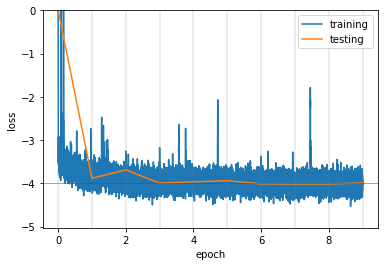

Batch:   0 Loss = -3.926299e+00,
Batch:  10 Loss = -4.066859e+00,
Batch:  20 Loss = -3.940425e+00,
Batch:  30 Loss = -4.223573e+00,
Batch:  40 Loss = -4.144241e+00,
Batch:  50 Loss = -3.946518e+00,
Batch:  60 Loss = -3.832504e+00,
Batch:  70 Loss = -4.074413e+00,
Batch:  80 Loss = -3.964261e+00,
Batch:  90 Loss = -3.940046e+00,
Batch: 100 Loss = -4.117326e+00,
Batch: 110 Loss = -3.910678e+00,
Batch: 120 Loss = -4.123887e+00,
Batch: 130 Loss = -4.045212e+00,
Batch: 140 Loss = -4.166076e+00,
Batch: 150 Loss = -4.062853e+00,
Batch: 160 Loss = -3.962511e+00,
Batch: 170 Loss = -4.243036e+00,
Batch: 180 Loss = -3.890683e+00,
Batch: 190 Loss = -4.111775e+00,
Batch: 200 Loss = -3.884541e+00,
Batch: 210 Loss = -4.013394e+00,
Batch: 220 Loss = -3.819049e+00,
Batch: 230 Loss = -3.954340e+00,
Batch: 240 Loss = -4.000244e+00,
Batch: 250 Loss = -4.092439e+00,
Batch: 260 Loss = -3.953186e+00,
Batch: 270 Loss = -3.826467e+00,
Batch: 280 Loss = -3.782268e+00,
Batch: 290 Loss = -4.064652e+00,
Batch: 300

Batch: 2440 Loss = -3.836549e+00,
Batch: 2450 Loss = -4.024900e+00,
Batch: 2460 Loss = -3.849530e+00,
Batch: 2470 Loss = -4.183141e+00,
Batch: 2480 Loss = -3.995957e+00,
Batch: 2490 Loss = -3.994797e+00,
Batch: 2500 Loss = -4.085408e+00,
Batch: 2510 Loss = -4.106879e+00,
Batch: 2520 Loss = -4.143268e+00,
Batch: 2530 Loss = -4.032342e+00,
Batch: 2540 Loss = -3.967562e+00,
Batch: 2550 Loss = -3.954240e+00,
Batch: 2560 Loss = -4.202495e+00,
Batch: 2570 Loss = -4.071603e+00,
Batch: 2580 Loss = -4.022579e+00,
Batch: 2590 Loss = -4.057212e+00,
Batch: 2600 Loss = -4.008566e+00,
Batch: 2610 Loss = -4.099923e+00,
Batch: 2620 Loss = -4.142556e+00,
Batch: 2630 Loss = -4.231667e+00,
Batch: 2640 Loss = -4.026744e+00,
Batch: 2650 Loss = -4.219582e+00,
Batch: 2660 Loss = -4.062000e+00,
Batch: 2670 Loss = -3.885778e+00,
Batch: 2680 Loss = -4.019380e+00,
Batch: 2690 Loss = -4.168883e+00,
Batch: 2700 Loss = -3.946335e+00,
Batch: 2710 Loss = -3.920776e+00,
Batch: 2720 Loss = -3.788781e+00,
Batch: 2730 Lo

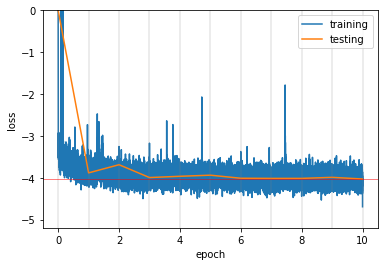

Batch:   0 Loss = -4.218017e+00,
Batch:  10 Loss = -4.295321e+00,
Batch:  20 Loss = -3.867465e+00,
Batch:  30 Loss = -4.141505e+00,
Batch:  40 Loss = -3.951293e+00,
Batch:  50 Loss = -3.967967e+00,
Batch:  60 Loss = -4.201312e+00,
Batch:  70 Loss = -4.169280e+00,
Batch:  80 Loss = -4.024081e+00,
Batch:  90 Loss = -3.728216e+00,
Batch: 100 Loss = -3.920414e+00,
Batch: 110 Loss = -4.283001e+00,
Batch: 120 Loss = -3.802168e+00,
Batch: 130 Loss = -4.109531e+00,
Batch: 140 Loss = -4.031856e+00,
Batch: 150 Loss = -3.906611e+00,
Batch: 160 Loss = -3.890185e+00,
Batch: 170 Loss = -4.178097e+00,
Batch: 180 Loss = -4.262055e+00,
Batch: 190 Loss = -4.152185e+00,
Batch: 200 Loss = -4.198945e+00,
Batch: 210 Loss = -3.722299e+00,
Batch: 220 Loss = -4.029392e+00,
Batch: 230 Loss = -3.824783e+00,
Batch: 240 Loss = -4.059893e+00,
Batch: 250 Loss = -4.067961e+00,
Batch: 260 Loss = -3.958911e+00,
Batch: 270 Loss = -3.998880e+00,
Batch: 280 Loss = -4.098039e+00,
Batch: 290 Loss = -3.870411e+00,
Batch: 300

Batch: 2440 Loss = -3.857617e+00,
Batch: 2450 Loss = -4.137149e+00,
Batch: 2460 Loss = -3.984769e+00,
Batch: 2470 Loss = -3.775693e+00,
Batch: 2480 Loss = -4.178192e+00,
Batch: 2490 Loss = -3.940677e+00,
Batch: 2500 Loss = -4.008232e+00,
Batch: 2510 Loss = -3.998293e+00,
Batch: 2520 Loss = -4.022265e+00,
Batch: 2530 Loss = -3.966064e+00,
Batch: 2540 Loss = -4.098181e+00,
Batch: 2550 Loss = -3.982224e+00,
Batch: 2560 Loss = -4.069956e+00,
Batch: 2570 Loss = -4.119054e+00,
Batch: 2580 Loss = -4.108301e+00,
Batch: 2590 Loss = -4.358370e+00,
Batch: 2600 Loss = -3.978733e+00,
Batch: 2610 Loss = -4.087583e+00,
Batch: 2620 Loss = -4.145534e+00,
Batch: 2630 Loss = -4.051897e+00,
Batch: 2640 Loss = -3.930956e+00,
Batch: 2650 Loss = -4.182114e+00,
Batch: 2660 Loss = -3.946008e+00,
Batch: 2670 Loss = -4.086615e+00,
Batch: 2680 Loss = -3.939722e+00,
Batch: 2690 Loss = -3.976674e+00,
Batch: 2700 Loss = -4.031881e+00,
Batch: 2710 Loss = -4.118293e+00,
Batch: 2720 Loss = -4.037161e+00,
Batch: 2730 Lo

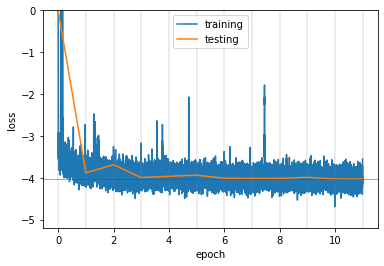

Batch:   0 Loss = -3.998696e+00,
Batch:  10 Loss = -3.871159e+00,
Batch:  20 Loss = -3.709035e+00,
Batch:  30 Loss = -3.964964e+00,
Batch:  40 Loss = -4.050568e+00,
Batch:  50 Loss = -3.899730e+00,
Batch:  60 Loss = -4.108344e+00,
Batch:  70 Loss = -3.807700e+00,
Batch:  80 Loss = -4.199126e+00,
Batch:  90 Loss = -4.077827e+00,
Batch: 100 Loss = -4.118473e+00,
Batch: 110 Loss = -3.918771e+00,
Batch: 120 Loss = -3.954441e+00,
Batch: 130 Loss = -3.986169e+00,
Batch: 140 Loss = -3.999170e+00,
Batch: 150 Loss = -4.016617e+00,
Batch: 160 Loss = -4.025531e+00,
Batch: 170 Loss = -4.062135e+00,
Batch: 180 Loss = -4.101288e+00,
Batch: 190 Loss = -4.228519e+00,
Batch: 200 Loss = -3.968365e+00,
Batch: 210 Loss = -4.092841e+00,
Batch: 220 Loss = -4.038882e+00,
Batch: 230 Loss = -3.797081e+00,
Batch: 240 Loss = -3.946212e+00,
Batch: 250 Loss = -3.922382e+00,
Batch: 260 Loss = -3.952200e+00,
Batch: 270 Loss = -3.968623e+00,
Batch: 280 Loss = -3.774529e+00,
Batch: 290 Loss = -4.071297e+00,
Batch: 300

Batch: 2440 Loss = -4.194505e+00,
Batch: 2450 Loss = -4.050883e+00,
Batch: 2460 Loss = -4.033634e+00,
Batch: 2470 Loss = -3.868748e+00,
Batch: 2480 Loss = -3.879737e+00,
Batch: 2490 Loss = -4.049997e+00,
Batch: 2500 Loss = -4.180614e+00,
Batch: 2510 Loss = -4.121815e+00,
Batch: 2520 Loss = -4.188487e+00,
Batch: 2530 Loss = -4.014195e+00,
Batch: 2540 Loss = -3.940848e+00,
Batch: 2550 Loss = -3.863163e+00,
Batch: 2560 Loss = -4.052062e+00,
Batch: 2570 Loss = -3.977689e+00,
Batch: 2580 Loss = -4.045405e+00,
Batch: 2590 Loss = -4.005580e+00,
Batch: 2600 Loss = -4.179703e+00,
Batch: 2610 Loss = -4.173708e+00,
Batch: 2620 Loss = -3.936551e+00,
Batch: 2630 Loss = -3.971391e+00,
Batch: 2640 Loss = -4.034117e+00,
Batch: 2650 Loss = -4.085772e+00,
Batch: 2660 Loss = -3.952966e+00,
Batch: 2670 Loss = -4.227392e+00,
Batch: 2680 Loss = -4.039738e+00,
Batch: 2690 Loss = -4.283654e+00,
Batch: 2700 Loss = -3.851209e+00,
Batch: 2710 Loss = -3.993949e+00,
Batch: 2720 Loss = -3.930844e+00,
Batch: 2730 Lo

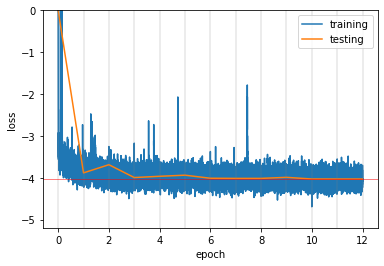

Batch:   0 Loss = -3.939224e+00,
Batch:  10 Loss = -4.049161e+00,
Batch:  20 Loss = -3.843988e+00,
Batch:  30 Loss = -4.165688e+00,
Batch:  40 Loss = -4.219155e+00,
Batch:  50 Loss = -4.004633e+00,
Batch:  60 Loss = -4.007645e+00,
Batch:  70 Loss = -4.057198e+00,
Batch:  80 Loss = -3.911052e+00,
Batch:  90 Loss = -4.057922e+00,
Batch: 100 Loss = -4.158874e+00,
Batch: 110 Loss = -4.115147e+00,
Batch: 120 Loss = -4.118594e+00,
Batch: 130 Loss = -4.094842e+00,
Batch: 140 Loss = -4.100469e+00,
Batch: 150 Loss = -4.097739e+00,
Batch: 160 Loss = -4.008299e+00,
Batch: 170 Loss = -4.042220e+00,
Batch: 180 Loss = -4.095191e+00,
Batch: 190 Loss = -4.015306e+00,
Batch: 200 Loss = -4.290503e+00,
Batch: 210 Loss = -4.135381e+00,
Batch: 220 Loss = -4.233303e+00,
Batch: 230 Loss = -4.143894e+00,
Batch: 240 Loss = -4.345951e+00,
Batch: 250 Loss = -3.973552e+00,
Batch: 260 Loss = -3.787145e+00,
Batch: 270 Loss = -4.243508e+00,
Batch: 280 Loss = -3.962430e+00,
Batch: 290 Loss = -4.126734e+00,
Batch: 300

Batch: 2440 Loss = -4.067701e+00,
Batch: 2450 Loss = -4.265395e+00,
Batch: 2460 Loss = -3.973332e+00,
Batch: 2470 Loss = -4.008554e+00,
Batch: 2480 Loss = -3.856714e+00,
Batch: 2490 Loss = -4.041712e+00,
Batch: 2500 Loss = -4.033691e+00,
Batch: 2510 Loss = -3.940719e+00,
Batch: 2520 Loss = -4.075095e+00,
Batch: 2530 Loss = -4.187254e+00,
Batch: 2540 Loss = -4.177255e+00,
Batch: 2550 Loss = -4.169573e+00,
Batch: 2560 Loss = -4.034316e+00,
Batch: 2570 Loss = -4.112168e+00,
Batch: 2580 Loss = -3.860256e+00,
Batch: 2590 Loss = -3.935414e+00,
Batch: 2600 Loss = -3.814389e+00,
Batch: 2610 Loss = -4.213743e+00,
Batch: 2620 Loss = -4.040978e+00,
Batch: 2630 Loss = -4.126859e+00,
Batch: 2640 Loss = -4.122357e+00,
Batch: 2650 Loss = -3.963789e+00,
Batch: 2660 Loss = -4.050851e+00,
Batch: 2670 Loss = -4.215967e+00,
Batch: 2680 Loss = -3.980554e+00,
Batch: 2690 Loss = -4.113523e+00,
Batch: 2700 Loss = -3.573201e+00,
Batch: 2710 Loss = -3.891626e+00,
Batch: 2720 Loss = -4.081977e+00,
Batch: 2730 Lo

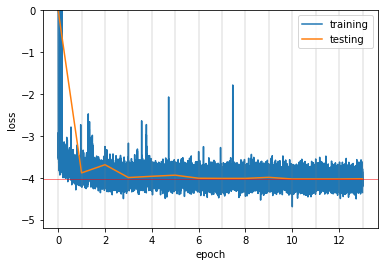

Batch:   0 Loss = -3.889880e+00,
Batch:  10 Loss = -3.966700e+00,
Batch:  20 Loss = -3.855807e+00,
Batch:  30 Loss = -4.156749e+00,
Batch:  40 Loss = -4.231910e+00,
Batch:  50 Loss = -4.184685e+00,
Batch:  60 Loss = -4.070943e+00,
Batch:  70 Loss = -4.082492e+00,
Batch:  80 Loss = -3.845557e+00,
Batch:  90 Loss = -4.120254e+00,
Batch: 100 Loss = -3.780221e+00,
Batch: 110 Loss = -3.818742e+00,
Batch: 120 Loss = -3.952704e+00,
Batch: 130 Loss = -3.871212e+00,
Batch: 140 Loss = -4.066654e+00,
Batch: 150 Loss = -4.182118e+00,
Batch: 160 Loss = -4.118750e+00,
Batch: 170 Loss = -4.078848e+00,
Batch: 180 Loss = -3.899852e+00,
Batch: 190 Loss = -4.184461e+00,
Batch: 200 Loss = -4.179231e+00,
Batch: 210 Loss = -4.176230e+00,
Batch: 220 Loss = -4.001453e+00,
Batch: 230 Loss = -3.960118e+00,
Batch: 240 Loss = -4.005102e+00,
Batch: 250 Loss = -4.056987e+00,
Batch: 260 Loss = -4.021518e+00,
Batch: 270 Loss = -4.215812e+00,
Batch: 280 Loss = -4.017952e+00,
Batch: 290 Loss = -4.213262e+00,
Batch: 300

Batch: 2440 Loss = -3.985126e+00,
Batch: 2450 Loss = -4.288053e+00,
Batch: 2460 Loss = -3.908004e+00,
Batch: 2470 Loss = -4.043707e+00,
Batch: 2480 Loss = -3.867317e+00,
Batch: 2490 Loss = -3.920827e+00,
Batch: 2500 Loss = -3.979191e+00,
Batch: 2510 Loss = -3.983550e+00,
Batch: 2520 Loss = -3.937528e+00,
Batch: 2530 Loss = -4.103348e+00,
Batch: 2540 Loss = -4.040168e+00,
Batch: 2550 Loss = -3.965273e+00,
Batch: 2560 Loss = -4.095948e+00,
Batch: 2570 Loss = -3.687177e+00,
Batch: 2580 Loss = -4.250410e+00,
Batch: 2590 Loss = -4.144654e+00,
Batch: 2600 Loss = -3.997260e+00,
Batch: 2610 Loss = -3.880079e+00,
Batch: 2620 Loss = -4.201741e+00,
Batch: 2630 Loss = -4.191099e+00,
Batch: 2640 Loss = -4.117984e+00,
Batch: 2650 Loss = -3.903481e+00,
Batch: 2660 Loss = -4.001081e+00,
Batch: 2670 Loss = -3.745548e+00,
Batch: 2680 Loss = -3.849829e+00,
Batch: 2690 Loss = -4.051650e+00,
Batch: 2700 Loss = -3.944948e+00,
Batch: 2710 Loss = -4.192100e+00,
Batch: 2720 Loss = -4.007063e+00,
Batch: 2730 Lo

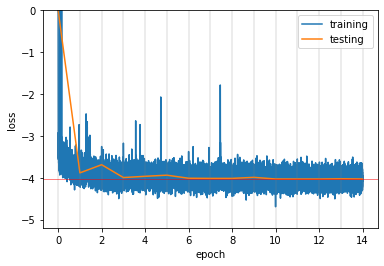

Batch:   0 Loss = -4.128435e+00,
Batch:  10 Loss = -4.214022e+00,
Batch:  20 Loss = -3.983127e+00,
Batch:  30 Loss = -3.992241e+00,
Batch:  40 Loss = -4.025523e+00,
Batch:  50 Loss = -4.037625e+00,
Batch:  60 Loss = -4.076907e+00,
Batch:  70 Loss = -3.978518e+00,
Batch:  80 Loss = -4.106317e+00,
Batch:  90 Loss = -3.926676e+00,
Batch: 100 Loss = -4.244192e+00,
Batch: 110 Loss = -4.104839e+00,
Batch: 120 Loss = -4.106151e+00,
Batch: 130 Loss = -3.998617e+00,
Batch: 140 Loss = -3.804083e+00,
Batch: 150 Loss = -3.877513e+00,
Batch: 160 Loss = -4.074580e+00,
Batch: 170 Loss = -4.209200e+00,
Batch: 180 Loss = -3.898629e+00,
Batch: 190 Loss = -4.231807e+00,
Batch: 200 Loss = -4.216823e+00,
Batch: 210 Loss = -4.248960e+00,
Batch: 220 Loss = -4.019023e+00,
Batch: 230 Loss = -4.076995e+00,
Batch: 240 Loss = -4.241689e+00,
Batch: 250 Loss = -4.123949e+00,
Batch: 260 Loss = -4.119845e+00,
Batch: 270 Loss = -3.893810e+00,
Batch: 280 Loss = -3.943917e+00,
Batch: 290 Loss = -4.289685e+00,
Batch: 300

Batch: 2440 Loss = -3.907438e+00,
Batch: 2450 Loss = -4.230823e+00,
Batch: 2460 Loss = -3.934750e+00,
Batch: 2470 Loss = -3.807523e+00,
Batch: 2480 Loss = -4.186221e+00,
Batch: 2490 Loss = -3.993677e+00,
Batch: 2500 Loss = -3.735951e+00,
Batch: 2510 Loss = -3.791166e+00,
Batch: 2520 Loss = -4.024330e+00,
Batch: 2530 Loss = -3.988055e+00,
Batch: 2540 Loss = -4.030276e+00,
Batch: 2550 Loss = -3.995928e+00,
Batch: 2560 Loss = -4.109964e+00,
Batch: 2570 Loss = -4.025225e+00,
Batch: 2580 Loss = -4.029756e+00,
Batch: 2590 Loss = -4.075074e+00,
Batch: 2600 Loss = -4.047462e+00,
Batch: 2610 Loss = -4.334235e+00,
Batch: 2620 Loss = -4.105776e+00,
Batch: 2630 Loss = -4.081389e+00,
Batch: 2640 Loss = -4.053301e+00,
Batch: 2650 Loss = -3.988259e+00,
Batch: 2660 Loss = -4.219439e+00,
Batch: 2670 Loss = -3.993494e+00,
Batch: 2680 Loss = -3.938564e+00,
Batch: 2690 Loss = -3.977053e+00,
Batch: 2700 Loss = -3.906076e+00,
Batch: 2710 Loss = -4.154554e+00,
Batch: 2720 Loss = -4.129468e+00,
Batch: 2730 Lo

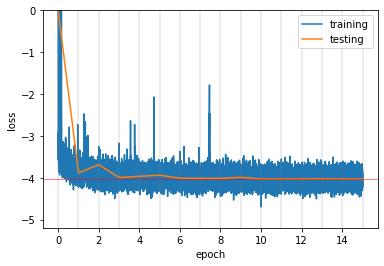

Batch:   0 Loss = -4.144761e+00,
Batch:  10 Loss = -4.149673e+00,
Batch:  20 Loss = -3.821958e+00,
Batch:  30 Loss = -4.178435e+00,
Batch:  40 Loss = -3.985896e+00,
Batch:  50 Loss = -3.960044e+00,
Batch:  60 Loss = -4.146797e+00,
Batch:  70 Loss = -4.021463e+00,
Batch:  80 Loss = -4.152318e+00,
Batch:  90 Loss = -3.937557e+00,
Batch: 100 Loss = -4.106630e+00,
Batch: 110 Loss = -3.890755e+00,
Batch: 120 Loss = -3.958491e+00,
Batch: 130 Loss = -4.160190e+00,
Batch: 140 Loss = -3.746336e+00,
Batch: 150 Loss = -3.990389e+00,
Batch: 160 Loss = -3.993175e+00,
Batch: 170 Loss = -3.946308e+00,
Batch: 180 Loss = -3.880281e+00,
Batch: 190 Loss = -3.969149e+00,
Batch: 200 Loss = -3.904616e+00,
Batch: 210 Loss = -4.202592e+00,
Batch: 220 Loss = -4.046244e+00,
Batch: 230 Loss = -3.854945e+00,
Batch: 240 Loss = -4.140000e+00,
Batch: 250 Loss = -4.024240e+00,
Batch: 260 Loss = -4.038534e+00,
Batch: 270 Loss = -3.875262e+00,
Batch: 280 Loss = -3.725704e+00,
Batch: 290 Loss = -3.853313e+00,
Batch: 300

Batch: 2440 Loss = -4.068560e+00,
Batch: 2450 Loss = -4.085822e+00,
Batch: 2460 Loss = -4.091521e+00,
Batch: 2470 Loss = -3.980052e+00,
Batch: 2480 Loss = -4.032180e+00,
Batch: 2490 Loss = -4.037392e+00,
Batch: 2500 Loss = -3.857509e+00,
Batch: 2510 Loss = -3.906587e+00,
Batch: 2520 Loss = -4.190342e+00,
Batch: 2530 Loss = -3.992992e+00,
Batch: 2540 Loss = -3.929788e+00,
Batch: 2550 Loss = -3.858500e+00,
Batch: 2560 Loss = -4.053190e+00,
Batch: 2570 Loss = -4.077704e+00,
Batch: 2580 Loss = -4.045565e+00,
Batch: 2590 Loss = -4.078889e+00,
Batch: 2600 Loss = -3.832563e+00,
Batch: 2610 Loss = -4.246367e+00,
Batch: 2620 Loss = -4.145747e+00,
Batch: 2630 Loss = -4.014762e+00,
Batch: 2640 Loss = -4.026190e+00,
Batch: 2650 Loss = -3.871339e+00,
Batch: 2660 Loss = -4.001564e+00,
Batch: 2670 Loss = -4.094998e+00,
Batch: 2680 Loss = -4.152687e+00,
Batch: 2690 Loss = -4.097382e+00,
Batch: 2700 Loss = -3.918128e+00,
Batch: 2710 Loss = -3.957819e+00,
Batch: 2720 Loss = -4.156021e+00,
Batch: 2730 Lo

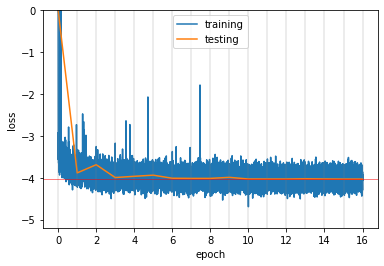

Batch:   0 Loss = -3.968609e+00,
Batch:  10 Loss = -3.794447e+00,
Batch:  20 Loss = -4.102528e+00,
Batch:  30 Loss = -4.098868e+00,
Batch:  40 Loss = -3.939203e+00,
Batch:  50 Loss = -3.957824e+00,
Batch:  60 Loss = -4.194548e+00,
Batch:  70 Loss = -3.865576e+00,
Batch:  80 Loss = -3.924503e+00,
Batch:  90 Loss = -4.074946e+00,
Batch: 100 Loss = -3.941470e+00,
Batch: 110 Loss = -4.251179e+00,
Batch: 120 Loss = -4.145294e+00,
Batch: 130 Loss = -4.106751e+00,
Batch: 140 Loss = -4.178503e+00,
Batch: 150 Loss = -3.905955e+00,
Batch: 160 Loss = -4.059570e+00,
Batch: 170 Loss = -3.769305e+00,
Batch: 180 Loss = -3.911050e+00,
Batch: 190 Loss = -3.915836e+00,
Batch: 200 Loss = -4.089846e+00,
Batch: 210 Loss = -4.147751e+00,
Batch: 220 Loss = -4.037432e+00,
Batch: 230 Loss = -4.016547e+00,
Batch: 240 Loss = -3.941634e+00,
Batch: 250 Loss = -3.966618e+00,
Batch: 260 Loss = -3.962196e+00,
Batch: 270 Loss = -4.124705e+00,
Batch: 280 Loss = -4.051493e+00,
Batch: 290 Loss = -4.044223e+00,
Batch: 300

Batch: 2440 Loss = -3.967273e+00,
Batch: 2450 Loss = -3.930925e+00,
Batch: 2460 Loss = -4.239233e+00,
Batch: 2470 Loss = -4.141206e+00,
Batch: 2480 Loss = -3.876782e+00,
Batch: 2490 Loss = -3.912650e+00,
Batch: 2500 Loss = -4.186116e+00,
Batch: 2510 Loss = -3.960648e+00,
Batch: 2520 Loss = -4.151591e+00,
Batch: 2530 Loss = -4.136738e+00,
Batch: 2540 Loss = -3.971218e+00,
Batch: 2550 Loss = -4.109047e+00,
Batch: 2560 Loss = -3.955098e+00,
Batch: 2570 Loss = -3.964827e+00,
Batch: 2580 Loss = -3.935044e+00,
Batch: 2590 Loss = -4.032385e+00,
Batch: 2600 Loss = -4.110907e+00,
Batch: 2610 Loss = -4.323366e+00,
Batch: 2620 Loss = -3.919309e+00,
Batch: 2630 Loss = -4.117399e+00,
Batch: 2640 Loss = -3.939922e+00,
Batch: 2650 Loss = -4.097708e+00,
Batch: 2660 Loss = -3.882527e+00,
Batch: 2670 Loss = -4.047431e+00,
Batch: 2680 Loss = -4.132115e+00,
Batch: 2690 Loss = -4.051294e+00,
Batch: 2700 Loss = -4.010167e+00,
Batch: 2710 Loss = -4.145218e+00,
Batch: 2720 Loss = -3.857521e+00,
Batch: 2730 Lo

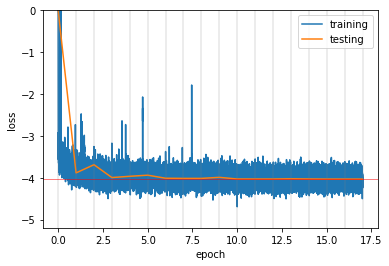

Batch:   0 Loss = -3.740564e+00,
Batch:  10 Loss = -4.080348e+00,
Batch:  20 Loss = -4.062928e+00,
Batch:  30 Loss = -4.031922e+00,
Batch:  40 Loss = -3.843317e+00,
Batch:  50 Loss = -4.122821e+00,
Batch:  60 Loss = -3.964499e+00,
Batch:  70 Loss = -3.989540e+00,
Batch:  80 Loss = -3.831034e+00,
Batch:  90 Loss = -4.167810e+00,
Batch: 100 Loss = -4.278704e+00,
Batch: 110 Loss = -3.869767e+00,
Batch: 120 Loss = -3.946144e+00,
Batch: 130 Loss = -4.087080e+00,
Batch: 140 Loss = -3.908759e+00,
Batch: 150 Loss = -3.959570e+00,
Batch: 160 Loss = -3.828736e+00,
Batch: 170 Loss = -4.196669e+00,
Batch: 180 Loss = -4.038933e+00,
Batch: 190 Loss = -4.050645e+00,
Batch: 200 Loss = -4.046804e+00,
Batch: 210 Loss = -4.291112e+00,
Batch: 220 Loss = -4.147209e+00,
Batch: 230 Loss = -4.089765e+00,
Batch: 240 Loss = -3.481622e+00,
Batch: 250 Loss = -4.013699e+00,
Batch: 260 Loss = -3.828392e+00,
Batch: 270 Loss = -4.130117e+00,
Batch: 280 Loss = -3.766973e+00,
Batch: 290 Loss = -4.142984e+00,
Batch: 300

Batch: 2440 Loss = -4.099068e+00,
Batch: 2450 Loss = -3.943000e+00,
Batch: 2460 Loss = -3.976372e+00,
Batch: 2470 Loss = -4.017682e+00,
Batch: 2480 Loss = -4.064685e+00,
Batch: 2490 Loss = -4.190368e+00,
Batch: 2500 Loss = -4.064991e+00,
Batch: 2510 Loss = -4.319540e+00,
Batch: 2520 Loss = -3.749609e+00,
Batch: 2530 Loss = -3.808142e+00,
Batch: 2540 Loss = -4.117843e+00,
Batch: 2550 Loss = -3.893270e+00,
Batch: 2560 Loss = -4.167534e+00,
Batch: 2570 Loss = -3.872703e+00,
Batch: 2580 Loss = -3.936709e+00,
Batch: 2590 Loss = -4.032963e+00,
Batch: 2600 Loss = -4.002317e+00,
Batch: 2610 Loss = -4.200240e+00,
Batch: 2620 Loss = -3.895512e+00,
Batch: 2630 Loss = -3.902869e+00,
Batch: 2640 Loss = -4.220556e+00,
Batch: 2650 Loss = -4.095413e+00,
Batch: 2660 Loss = -3.825780e+00,
Batch: 2670 Loss = -4.119789e+00,
Batch: 2680 Loss = -4.009165e+00,
Batch: 2690 Loss = -4.348842e+00,
Batch: 2700 Loss = -3.974982e+00,
Batch: 2710 Loss = -4.049736e+00,
Batch: 2720 Loss = -4.005575e+00,
Batch: 2730 Lo

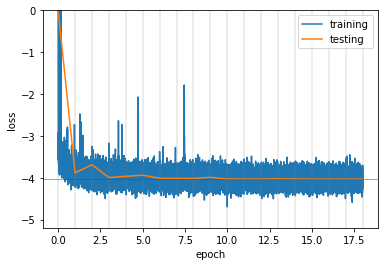

Batch:   0 Loss = -3.722167e+00,
Batch:  10 Loss = -4.142511e+00,
Batch:  20 Loss = -4.128200e+00,
Batch:  30 Loss = -4.016710e+00,
Batch:  40 Loss = -3.755590e+00,
Batch:  50 Loss = -3.990318e+00,
Batch:  60 Loss = -3.940439e+00,
Batch:  70 Loss = -4.023920e+00,
Batch:  80 Loss = -4.191379e+00,
Batch:  90 Loss = -3.946421e+00,
Batch: 100 Loss = -3.797837e+00,
Batch: 110 Loss = -4.006746e+00,
Batch: 120 Loss = -4.163738e+00,
Batch: 130 Loss = -4.216248e+00,
Batch: 140 Loss = -3.929837e+00,
Batch: 150 Loss = -4.011728e+00,
Batch: 160 Loss = -4.145292e+00,
Batch: 170 Loss = -4.119924e+00,
Batch: 180 Loss = -4.045550e+00,
Batch: 190 Loss = -3.743129e+00,
Batch: 200 Loss = -3.840788e+00,
Batch: 210 Loss = -4.238873e+00,
Batch: 220 Loss = -3.829257e+00,
Batch: 230 Loss = -3.696277e+00,
Batch: 240 Loss = -4.261836e+00,
Batch: 250 Loss = -4.039111e+00,
Batch: 260 Loss = -4.045826e+00,
Batch: 270 Loss = -4.118733e+00,
Batch: 280 Loss = -3.992667e+00,
Batch: 290 Loss = -3.979128e+00,
Batch: 300

Batch: 2440 Loss = -4.075568e+00,
Batch: 2450 Loss = -4.031062e+00,
Batch: 2460 Loss = -4.040590e+00,
Batch: 2470 Loss = -3.987347e+00,
Batch: 2480 Loss = -3.948285e+00,
Batch: 2490 Loss = -3.825150e+00,
Batch: 2500 Loss = -4.039382e+00,
Batch: 2510 Loss = -3.889313e+00,
Batch: 2520 Loss = -4.264018e+00,
Batch: 2530 Loss = -4.090523e+00,
Batch: 2540 Loss = -3.962602e+00,
Batch: 2550 Loss = -4.078926e+00,
Batch: 2560 Loss = -4.147636e+00,
Batch: 2570 Loss = -3.955685e+00,
Batch: 2580 Loss = -4.097236e+00,
Batch: 2590 Loss = -3.915251e+00,
Batch: 2600 Loss = -4.335126e+00,
Batch: 2610 Loss = -4.020890e+00,
Batch: 2620 Loss = -4.241295e+00,
Batch: 2630 Loss = -4.160309e+00,
Batch: 2640 Loss = -4.104943e+00,
Batch: 2650 Loss = -4.066822e+00,
Batch: 2660 Loss = -4.264028e+00,
Batch: 2670 Loss = -4.127765e+00,
Batch: 2680 Loss = -4.046295e+00,
Batch: 2690 Loss = -3.870589e+00,
Batch: 2700 Loss = -4.051144e+00,
Batch: 2710 Loss = -4.293536e+00,
Batch: 2720 Loss = -3.913112e+00,
Batch: 2730 Lo

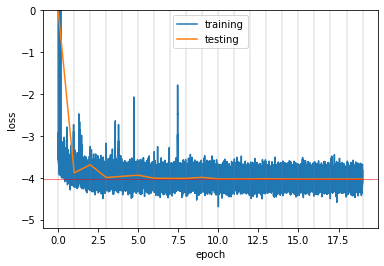

Batch:   0 Loss = -4.114757e+00,
Batch:  10 Loss = -4.028544e+00,
Batch:  20 Loss = -4.291253e+00,
Batch:  30 Loss = -3.808723e+00,
Batch:  40 Loss = -4.002803e+00,
Batch:  50 Loss = -4.045950e+00,
Batch:  60 Loss = -4.213444e+00,
Batch:  70 Loss = -4.230603e+00,
Batch:  80 Loss = -3.993312e+00,
Batch:  90 Loss = -4.023413e+00,
Batch: 100 Loss = -4.202878e+00,
Batch: 110 Loss = -3.926309e+00,
Batch: 120 Loss = -4.201303e+00,
Batch: 130 Loss = -3.957776e+00,
Batch: 140 Loss = -3.892748e+00,
Batch: 150 Loss = -4.100095e+00,
Batch: 160 Loss = -3.977780e+00,
Batch: 170 Loss = -4.249178e+00,
Batch: 180 Loss = -4.253810e+00,
Batch: 190 Loss = -4.256753e+00,
Batch: 200 Loss = -3.974794e+00,
Batch: 210 Loss = -4.048048e+00,
Batch: 220 Loss = -3.969983e+00,
Batch: 230 Loss = -4.065517e+00,
Batch: 240 Loss = -3.971279e+00,
Batch: 250 Loss = -4.054909e+00,
Batch: 260 Loss = -3.970125e+00,
Batch: 270 Loss = -4.012668e+00,
Batch: 280 Loss = -3.937444e+00,
Batch: 290 Loss = -4.136940e+00,
Batch: 300

Batch: 2440 Loss = -3.831755e+00,
Batch: 2450 Loss = -3.877167e+00,
Batch: 2460 Loss = -4.197424e+00,
Batch: 2470 Loss = -3.943088e+00,
Batch: 2480 Loss = -4.076478e+00,
Batch: 2490 Loss = -3.968720e+00,
Batch: 2500 Loss = -4.097312e+00,
Batch: 2510 Loss = -3.877280e+00,
Batch: 2520 Loss = -4.042950e+00,
Batch: 2530 Loss = -4.143827e+00,
Batch: 2540 Loss = -3.909728e+00,
Batch: 2550 Loss = -4.115247e+00,
Batch: 2560 Loss = -3.983727e+00,
Batch: 2570 Loss = -3.892298e+00,
Batch: 2580 Loss = -3.871727e+00,
Batch: 2590 Loss = -3.767581e+00,
Batch: 2600 Loss = -4.028540e+00,
Batch: 2610 Loss = -3.953656e+00,
Batch: 2620 Loss = -4.144369e+00,
Batch: 2630 Loss = -4.216598e+00,
Batch: 2640 Loss = -4.124717e+00,
Batch: 2650 Loss = -3.965270e+00,
Batch: 2660 Loss = -3.793799e+00,
Batch: 2670 Loss = -4.057062e+00,
Batch: 2680 Loss = -3.949502e+00,
Batch: 2690 Loss = -3.950213e+00,
Batch: 2700 Loss = -3.991812e+00,
Batch: 2710 Loss = -4.037396e+00,
Batch: 2720 Loss = -3.981007e+00,
Batch: 2730 Lo

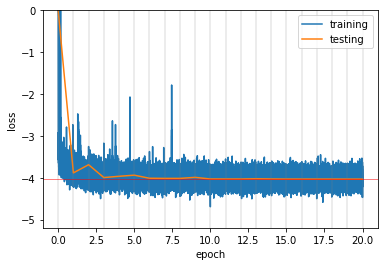

In [35]:
bkg_epochs = 20
bkgdist, losses, test_losses = train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                              issig=False, batchsize=128, lr=5e-3, epochs=bkg_epochs,
                              weight_decay=1e-5) #do not use learning rate schedule

Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully


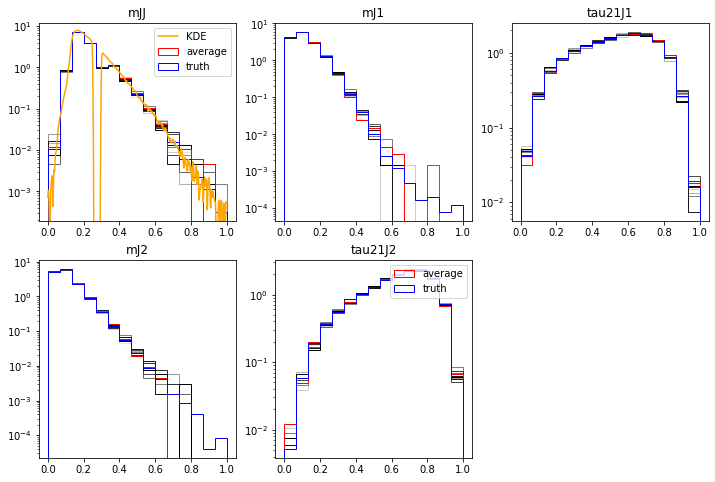

In [36]:
last_epochs = np.arange(bkg_epochs-10, bkg_epochs)
last_epochs = last_epochs[last_epochs >= 0]

plot_learned_distributions(bkgdist, last_epochs, 'bkg_', 10000,
                           truth=data_bkg_train.drop(columns='signal'), special_dim=0)

### Evaluate results of learning

In [37]:
combined.signal = combined.signal.astype(float)
data_SB, data_SR, invM = prepare_data_train(3500,200, 
                                             combined.query('dataset=="training"').drop(columns='dataset'),
                                             ignore=['signal'])
data_SR = tf.convert_to_tensor(data_SR.values)
data_SB = tf.convert_to_tensor(data_SB.values)

In [23]:
#mixed = tfd.Mixture(cat=tfd.Categorical(probs=[tf.cast(1./len(sigdist), dtype=tf.float64)]*len(sigdist)),
#                    components=list(sigdist))
#print(mixed.sample(1))
#mixed.prob(mixed.sample(1))

In [38]:
#mixed = tfd.Mixture(cat=tfd.Categorical(probs=[1./len(sigdist)]*len(sigdist)),
#                    components=list(sigdist))
#print(mixed.sample(1))
#mixed.prob(mixed.sample(1))

# since the commented part raises an exception, this is a temporary workaround.
def get_prob(dists, sample):
    # turn sample into DataFrame
    sample = pd.DataFrame(sample.numpy())
    
    # assign a random distribution to each data point
    sample['dist_no'] = np.random.randint(len(dists), size=len(sample))
    
    # get the probabilities
    sample['prob'] = 0.
    for i in range(len(dists)):
        sample.loc[sample.dist_no == i, 'prob'] = dists[i].prob(sample[sample.dist_no == i].drop(columns=['dist_no', 'prob']).values).numpy()
    return tf.convert_to_tensor(sample.prob.values)
    
# bkgprob = get_prob(bkgdist, data_sig[:, :5])
# bkgprob=bkgdist.prob(data_SR[:, :5])
# sigprob = get_prob(sigdist, data_sig[:, :5])
# sigprob=sigdist.prob(data_SR[:, :5])
# bkglogprob=np.log(bkgprob)

cast back into pandas DataFrames

In [39]:
data_sig = pd.DataFrame(data_SR.numpy(), columns=['mJJ', 'mJ1', 'tau21J1', 'tau21J2', 'diffm', 'signal'])
data_sig['mJJ_unscaled'] = invM
data_sig.signal = (data_sig.signal - np.min(data_sig.signal)).astype('bool')
issignal = data_sig['signal']
mlt = pd.MultiIndex.from_product([['observables'], data_sig.columns])
data_sig.columns = mlt

In [40]:
for epoch in np.arange(sig_epochs):
    if epoch % 5 != 0 and epoch != sig_epochs-1:
        continue
    print('calculating sig_prob for epoch', epoch)
    load_weights(sigdist, epoch=epoch, prefix='sig_')
    data_sig['signal', 'prob_E{}'.format(epoch)] = sigdist.prob(data_SR[:, :5]).numpy()

calculating sig_prob for epoch 0
Model loaded successfully
calculating sig_prob for epoch 5
Model loaded successfully
calculating sig_prob for epoch 10
Model loaded successfully
calculating sig_prob for epoch 15
Model loaded successfully
calculating sig_prob for epoch 20
Model loaded successfully
calculating sig_prob for epoch 25
Model loaded successfully
calculating sig_prob for epoch 29
Model loaded successfully


In [41]:
plot_epochs = np.arange(0, bkg_epochs, 1)
if not bkg_epochs-1 in plot_epochs:
    plot_epochs = np.concatenate((plot_epochs, [bkg_epochs-1]))
print(plot_epochs)
Rc_values = np.linspace(0, 5, 50)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [42]:
use_sig_epoch = sig_epochs-1

for nn, epoch in enumerate(plot_epochs):
    print('calculating for background epoch', epoch)
    load_weights(bkgdist, epoch=epoch, prefix='bkg_')
    epoch_ID = 'E{}'.format(epoch)
    data_sig[epoch_ID, 'prob'] = bkgdist.prob(data_SR[:, :5]).numpy()
    data_sig[epoch_ID, 'logprob'] = np.log(data_sig[epoch_ID, 'prob'])
    data_sig[epoch_ID, 'R'] = data_sig['signal', 'prob_E{}'.format(use_sig_epoch)]/data_sig[epoch_ID, 'prob']

signals = data_sig[issignal].copy()
backgrounds = data_sig[~issignal].copy()
for nn, epoch in enumerate(plot_epochs):
    epoch_ID = 'E{}'.format(epoch)
    signals.sort_values(by=(epoch_ID, 'R'), ascending=False, inplace=True)
    signals[epoch_ID, 'count'] = np.arange(len(signals))
    backgrounds.sort_values(by=(epoch_ID, 'R'), ascending=False, inplace=True)
    backgrounds[epoch_ID, 'count'] = np.arange(len(backgrounds))

effs = pd.DataFrame(np.tile(Rc_values, len(plot_epochs)),
    columns = ['Rmin'],
    index=pd.MultiIndex.from_product([plot_epochs, np.arange(len(Rc_values))],
                                                     names=['epoch', 'idx']))
effs['sig_eff'] = effs.groupby('epoch').transform(
    lambda x: x.transform(lambda y: len(signals.loc[:, 'E{}'.format(x.index.values[0][0])].query('R > {}'.format(y)))/Nsig_SR)
                   )
effs['bkg_rej'] = effs.Rmin.groupby('epoch').transform(
    lambda x: x.transform(lambda y: Nbkg_SR/len(backgrounds.loc[:, 'E{}'.format(x.index.values[0][0])].query('R > {}'.format(y))))
                         )
effs['s_over_sqrtb'] = effs.sig_eff * np.sqrt(effs.bkg_rej)

calculating for background epoch 0
Model loaded successfully
calculating for background epoch 1
Model loaded successfully
calculating for background epoch 2
Model loaded successfully
calculating for background epoch 3
Model loaded successfully
calculating for background epoch 4
Model loaded successfully
calculating for background epoch 5
Model loaded successfully
calculating for background epoch 6
Model loaded successfully
calculating for background epoch 7
Model loaded successfully
calculating for background epoch 8
Model loaded successfully
calculating for background epoch 9
Model loaded successfully
calculating for background epoch 10
Model loaded successfully
calculating for background epoch 11
Model loaded successfully
calculating for background epoch 12
Model loaded successfully
calculating for background epoch 13
Model loaded successfully
calculating for background epoch 14
Model loaded successfully
calculating for background epoch 15
Model loaded successfully
calculating for ba

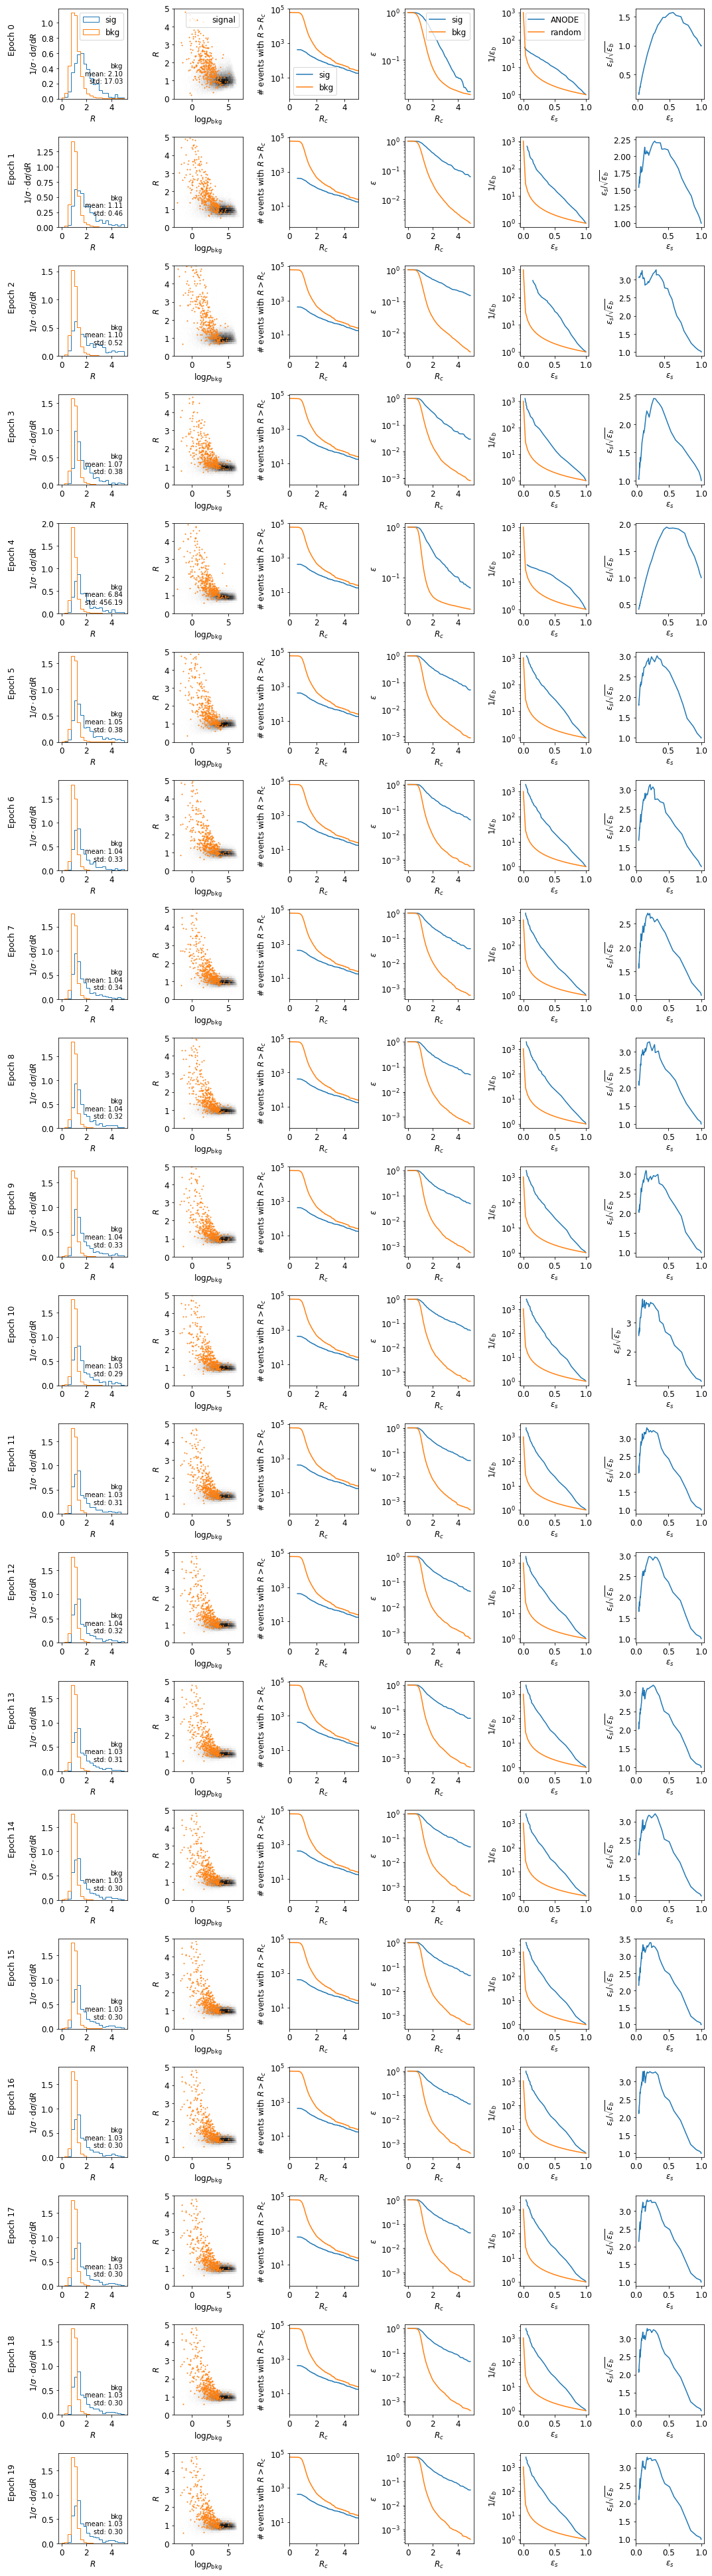

In [29]:
fs = 12
fig, axs = plt.subplots(len(plot_epochs), 7, figsize=(15, 2.7*len(plot_epochs)),
                        gridspec_kw={'width_ratios': [0.1, 1, 1, 1, 1, 1, 1]})
for nn, epoch in enumerate(plot_epochs):
    axs[nn, 0].text(0.5, 0.5, 'Epoch {}'.format(epoch), rotation=90, fontsize=fs)
    axs[nn, 0].axis('off')

    
    axs[nn, 1].hist(data_sig[issignal].loc[:, ('E{}'.format(epoch), 'R')],
                             bins=20, range=(0,5), histtype='step', density=True, label='sig')
    axs[nn, 1].hist(data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'R')],
                             bins=20, range=(0,5), histtype='step', density=True, label='bkg')
    axs[nn, 1].set_xlabel('$R$')
    axs[nn, 1].set_ylabel('$1/\sigma \cdot \mathrm{d}\sigma/\mathrm{d}R$')
    description = data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'R')].describe()
    axs[nn, 1].text(4.9, 0.2, 
                    'bkg\nmean: {:.2f}\nstd: {:.2f}'.format(
                        description.loc['mean'], description.loc['std']),
                    horizontalalignment='right'
                   )
    
    axs[nn, 2].hist2d(data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'logprob')],
                         data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'R')],
                         density=True, cmap='binary', bins=[95, 50], range=[(-2.5, 7), (0, 5)])
    axs[nn, 2].scatter(data_sig[issignal].loc[:, ('E{}'.format(epoch), 'logprob')],
                          data_sig[issignal].loc[:, ('E{}'.format(epoch), 'R')],
                          s=1, label='signal', color='C1')
    axs[nn, 2].set_ylim(0,5)
    axs[nn, 2].set_xlim(-2.5,7)
    axs[nn, 2].set_xlabel('$\log p_\mathrm{bkg}$')
    axs[nn, 2].set_ylabel('$R$')
    
    axs[nn, 3].plot(signals.loc[:, (epoch_ID, 'R')],
                       signals.loc[:, (epoch_ID, 'count')], label='sig')
    axs[nn, 3].plot(backgrounds.loc[:, (epoch_ID, 'R')],
                       backgrounds.loc[:, (epoch_ID, 'count')], label='bkg')
    axs[nn, 3].set_yscale('log')
    axs[nn, 3].set_ylabel('# events with $R > R_c$')
    axs[nn, 3].set_xlabel('$R_c$')
    axs[nn, 3].set_xlim(0,5)
    
    axs[nn, 4].plot(effs.loc[epoch].Rmin, effs.loc[epoch].sig_eff, label='sig')
    axs[nn, 4].plot(effs.loc[epoch].Rmin, 1/effs.loc[epoch].bkg_rej, label='bkg')
    axs[nn, 4].set_xlabel('$R_c$')
    axs[nn, 4].set_ylabel('$\epsilon$')
    axs[nn, 4].set_yscale('log')

    axs[nn, 5].plot(effs.loc[epoch].sig_eff, effs.loc[epoch].bkg_rej, label='ANODE')
    axs[nn, 5].plot(np.linspace(0.001, 1, 30), 1/np.linspace(0.001, 1, 30), label='random')
    axs[nn, 5].set_yscale('log')
    axs[nn, 5].set_xlabel('$\epsilon_s$')
    axs[nn, 5].set_ylabel('$1/\epsilon_b$')
    
    axs[nn, 6].plot(effs.loc[epoch].sig_eff, effs.loc[epoch].s_over_sqrtb)
    axs[nn, 6].set_xlabel('$\epsilon_s$')
    axs[nn, 6].set_ylabel('$\epsilon_s/\sqrt{\epsilon_b}$')

    if nn == 0:
        axs[nn, 1].legend(fontsize=fs)
        axs[nn, 2].legend(fontsize=fs)
        axs[nn, 3].legend(fontsize=fs)
        axs[nn, 4].legend(fontsize=fs)
        axs[nn, 5].legend(fontsize=fs)

for ax in axs.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)

plt.tight_layout()
plt.show()

KeyError: 'E25'

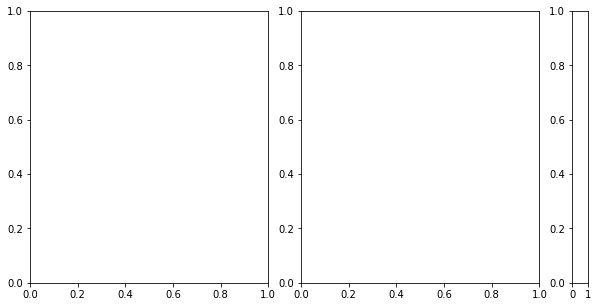

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 3, .2]})
Rc = 2.5
fs = 12

axs[0].hist(data_sig[data_sig.loc[:, 'E25'].R > Rc].loc[:, ('observables', 'mJJ_unscaled')])
axs[0].set_xlabel('$m_{JJ}$')
axs[0].set_ylabel('# events')

axs[1].hist(data_sig[data_sig.loc[:, 'E25'].R > Rc].loc[:, ('observables', 'diffm')])
axs[1].set_xlabel('$m_{J_1} - m_{J_2}$')
axs[1].set_ylabel('# events')


axs[2].text(0.5, 0.5, 'ABC', rotation=90, fontsize=20)
axs[2].axis('off')

for ax in axs.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)


plt.tight_layout()
plt.show()

## Train NN for signal-background discrimination

In [ ]:
# Get 10k events from learned distributions, requiring mJJ to be in the SR
events_per_category = 10000
mJJmin, mJJmax = min(data_sig.mJJ), max(data_sig.mJJ)
train_data = np.vstack((get_sample(bkgdist[-1], events_per_category, mJJmin, mJJmax),
                        get_sample(sigdist[-1], events_per_category, mJJmin, mJJmax)))
labels = np.concatenate((np.array([True]*events_per_category),
                    np.array([False]*events_per_category)))

In [ ]:
model = build_SB_NN(5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(train_data, labels, epochs=5)

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

### analyze results

In [ ]:
opt = {'range': (0.3, 0.7), 'histtype': 'step', 'density': True}
plt.hist(data_sig.sig_prob[data_sig.signal], label='signal', **opt)
plt.hist(data_sig.sig_prob[~data_sig.signal], label='background', **opt)
plt.xlabel('$p_\mathrm{sig}$')
plt.ylabel('normed')
plt.legend()
plt.show()

In [ ]:
plt.hist(data_sig.query('(sig_prob > .6)').diffm)
plt.show()

In [ ]:
signals = data_sig[issignal].copy()
signals.sort_values(by='sig_prob', ascending=False, inplace=True)
signals['count'] = np.arange(len(signals))

backgrounds = data_sig[~issignal].copy()
backgrounds.sort_values(by='sig_prob', ascending=False, inplace=True)
backgrounds['count'] = np.arange(len(backgrounds))

In [ ]:
plt.plot(signals.sig_prob, signals['count'], label='signal')
plt.plot(backgrounds.sig_prob, backgrounds['count'], label='background')
plt.yscale('log')
plt.ylabel('# events with $p_\mathrm{sig} > p_c$')
plt.xlabel('$p_c$')
plt.legend()
plt.savefig('Events_vs_pc.png')
plt.show()

In [ ]:
effs2 = pd.DataFrame(np.linspace(0, 1, 50), columns=['pc'])
effs2['sig_eff'] = effs2.pc.transform(lambda x: len(signals.query('sig_prob > {}'.format(x)))/Nsig_SR)
effs2['bkg_rej'] = effs2.pc.transform(lambda x: Nbkg_SR/max(1e-20, len(backgrounds.query('sig_prob > {}'.format(x)))))
effs2['s_over_sqrtb'] = effs2.sig_eff * np.sqrt(effs2.bkg_rej)

In [ ]:
plt.plot(effs2.pc, effs2.sig_eff, label='signal')
plt.plot(effs2.pc, 1/effs2.bkg_rej, label='background')
plt.xlabel('$p_c$')
plt.ylabel('efficiency')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()
plt.show()

In [ ]:
plt.plot(effs2.sig_eff, effs2.bkg_rej, label='ANODE+')
plt.plot(effs.sig_eff, effs.bkg_rej, label='ANODE')
plt.plot(np.linspace(0.001, 1, 30), 1/np.linspace(0.001, 1, 30), label='random')
plt.yscale('log')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.ylim(1, 1e3)
plt.legend()
plt.savefig('ROC.png')
plt.show()

In [ ]:
plt.plot(effs2.sig_eff, effs2.s_over_sqrtb, label='ANODE+')
plt.plot(effs.sig_eff, effs.s_over_sqrtb, label='ANODE')
plt.legend()
plt.xlabel('signal efficiency')
plt.ylabel('signal efficiency / $\sqrt{\mathrm{bkg~efficiency}}$')
plt.show()

## Old and obsolete

In [ ]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

In [ ]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [ ]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

In [ ]:
# f = lambda x: tfd.Independent(tfd.Normal(
#     loc=x, scale=tf.cast(0.002, dtype=tf.float64)))
# n = data_sig_train.mJJ.values.shape[0]
# kde_TF = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(probs=tf.cast([1 / n] * n, dtype=tf.float64)),
#         components_distribution=f(tf.cast(data_sig_train.mJJ.values[:n], dtype=tf.float64)))

In [ ]:
# values = tf.cast(np.array([value for value in np.linspace(0, 1, 500)]), dtype=tf.float64)
# probabilities = kde_TF.prob(values)
# plt.plot(values, probabilities)

# plt.hist(kde_TF.sample(1000), density=True)
# plt.show()